
# Imports

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Changing directory to Session 7 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/07_Advanced_Concepts/

/content/gdrive/My Drive/TSAI-EVA-7.0/07_Advanced_Concepts


# Data

In [ ]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

imgs = [item[0] for item in cifar_trainset] 
labels = [item[1] for item in cifar_trainset]

imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
mu = [mean_r,mean_g,mean_b]
print(mu)

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
sigma = [std_r,std_g,std_b]
print(sigma)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
[0.49139968, 0.48215827, 0.44653124]
[0.24703233, 0.24348505, 0.26158768]


## Visualization

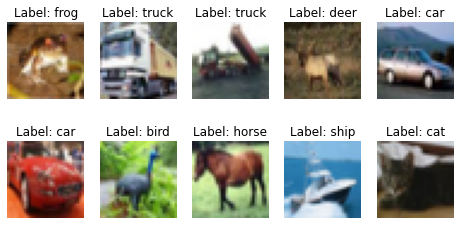

In [ ]:
# functions to show an image
def plot_grid(image, label):

    nrows = 2
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 4))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].set_title("Label: %s" % (classes[label[index]]))
            ax[i, j].imshow(np.transpose(image[index], (1, 2, 0)))

plot_grid(imgs[0:10], labels[0:10])

In [ ]:
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
      image, label = self.data[index], self.targets[index]
      
      if self.transform is not None:
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, label

In [ ]:
from augment import augmentation

trainset = Cifar10SearchDataset(root='./data', train=True, download=True, transform=augmentation('Train', mu, sigma))
testset = Cifar10SearchDataset(root='./data', train=False, download=True, transform=augmentation('Test', mu, sigma))

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders on GPU

In [ ]:
class args():
    def __init__(self,device = 'cpu',use_cuda = False):
        self.batch_size = 256
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 4, 'pin_memory': True} if self.use_cuda else {}

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=args(device, use_cuda).batch_size, shuffle=True, **args(device, use_cuda).kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args(device, use_cuda).batch_size, shuffle=True, **args(device, use_cuda).kwargs)

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model

In [ ]:
from model import Net
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             320
            Conv2d-5           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             320
            Conv2d-8           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             320
           Conv2d-11           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14

In [ ]:
import torch.optim as optim
import torch.nn as nn

EPOCHS = 1000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

# Training and testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0 

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)
    loss = criterion(y_pred, target)
    train_loss += loss
    loss.backward()
    optimizer.step()
        
    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader.dataset)
  train_losses.append(loss)
  train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
for epoch in range(EPOCHS):
  
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

  if test_acc[-1] >= 85.0: 
    break 

torch.save(model.state_dict(), './saved_models/model_weights.pth')

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.9154220819473267 Batch_id=195 Accuracy=24.37: 100%|██████████| 196/196 [00:08<00:00, 22.18it/s]



Test set: Average loss: 0.0085, Accuracy: 2277/10000 (22.77%)

EPOCH: 1


Loss=1.658494234085083 Batch_id=195 Accuracy=34.52: 100%|██████████| 196/196 [00:08<00:00, 22.33it/s]



Test set: Average loss: 0.0068, Accuracy: 3765/10000 (37.65%)

EPOCH: 2


Loss=1.5524917840957642 Batch_id=195 Accuracy=39.57: 100%|██████████| 196/196 [00:08<00:00, 22.22it/s]



Test set: Average loss: 0.0059, Accuracy: 4634/10000 (46.34%)

EPOCH: 3


Loss=1.4953203201293945 Batch_id=195 Accuracy=43.00: 100%|██████████| 196/196 [00:08<00:00, 22.27it/s]



Test set: Average loss: 0.0068, Accuracy: 4262/10000 (42.62%)

EPOCH: 4


Loss=1.339326024055481 Batch_id=195 Accuracy=45.68: 100%|██████████| 196/196 [00:08<00:00, 22.31it/s]



Test set: Average loss: 0.0054, Accuracy: 5118/10000 (51.18%)

EPOCH: 5


Loss=1.368481159210205 Batch_id=195 Accuracy=47.78: 100%|██████████| 196/196 [00:08<00:00, 22.12it/s]



Test set: Average loss: 0.0061, Accuracy: 4694/10000 (46.94%)

EPOCH: 6


Loss=1.306368112564087 Batch_id=195 Accuracy=49.15: 100%|██████████| 196/196 [00:08<00:00, 22.40it/s]



Test set: Average loss: 0.0051, Accuracy: 5336/10000 (53.36%)

EPOCH: 7


Loss=1.1848270893096924 Batch_id=195 Accuracy=50.80: 100%|██████████| 196/196 [00:08<00:00, 22.36it/s]



Test set: Average loss: 0.0050, Accuracy: 5586/10000 (55.86%)

EPOCH: 8


Loss=1.085991621017456 Batch_id=195 Accuracy=52.44: 100%|██████████| 196/196 [00:08<00:00, 22.25it/s]



Test set: Average loss: 0.0050, Accuracy: 5411/10000 (54.11%)

EPOCH: 9


Loss=1.2320233583450317 Batch_id=195 Accuracy=53.21: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]



Test set: Average loss: 0.0042, Accuracy: 6184/10000 (61.84%)

EPOCH: 10


Loss=1.231942892074585 Batch_id=195 Accuracy=54.42: 100%|██████████| 196/196 [00:08<00:00, 22.24it/s]



Test set: Average loss: 0.0052, Accuracy: 5693/10000 (56.93%)

EPOCH: 11


Loss=1.0825064182281494 Batch_id=195 Accuracy=55.24: 100%|██████████| 196/196 [00:08<00:00, 22.11it/s]



Test set: Average loss: 0.0040, Accuracy: 6522/10000 (65.22%)

EPOCH: 12


Loss=1.3096750974655151 Batch_id=195 Accuracy=56.18: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0040, Accuracy: 6435/10000 (64.35%)

EPOCH: 13


Loss=1.3443492650985718 Batch_id=195 Accuracy=56.81: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]



Test set: Average loss: 0.0039, Accuracy: 6488/10000 (64.88%)

EPOCH: 14


Loss=1.2469104528427124 Batch_id=195 Accuracy=57.33: 100%|██████████| 196/196 [00:08<00:00, 22.23it/s]



Test set: Average loss: 0.0038, Accuracy: 6658/10000 (66.58%)

EPOCH: 15


Loss=1.2032943964004517 Batch_id=195 Accuracy=57.87: 100%|██████████| 196/196 [00:08<00:00, 22.21it/s]



Test set: Average loss: 0.0041, Accuracy: 6514/10000 (65.14%)

EPOCH: 16


Loss=0.9950448870658875 Batch_id=195 Accuracy=58.80: 100%|██████████| 196/196 [00:08<00:00, 22.01it/s]



Test set: Average loss: 0.0038, Accuracy: 6648/10000 (66.48%)

EPOCH: 17


Loss=0.9470680952072144 Batch_id=195 Accuracy=59.08: 100%|██████████| 196/196 [00:08<00:00, 22.14it/s]



Test set: Average loss: 0.0038, Accuracy: 6611/10000 (66.11%)

EPOCH: 18


Loss=1.0328181982040405 Batch_id=195 Accuracy=59.74: 100%|██████████| 196/196 [00:08<00:00, 22.22it/s]



Test set: Average loss: 0.0040, Accuracy: 6516/10000 (65.16%)

EPOCH: 19


Loss=1.262941598892212 Batch_id=195 Accuracy=60.06: 100%|██████████| 196/196 [00:08<00:00, 22.02it/s]



Test set: Average loss: 0.0034, Accuracy: 7019/10000 (70.19%)

EPOCH: 20


Loss=0.9066494703292847 Batch_id=195 Accuracy=60.46: 100%|██████████| 196/196 [00:08<00:00, 22.08it/s]



Test set: Average loss: 0.0035, Accuracy: 6940/10000 (69.40%)

EPOCH: 21


Loss=1.2657883167266846 Batch_id=195 Accuracy=60.96: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0037, Accuracy: 6818/10000 (68.18%)

EPOCH: 22


Loss=1.3176381587982178 Batch_id=195 Accuracy=61.26: 100%|██████████| 196/196 [00:08<00:00, 22.05it/s]



Test set: Average loss: 0.0036, Accuracy: 6872/10000 (68.72%)

EPOCH: 23


Loss=0.91814786195755 Batch_id=195 Accuracy=61.74: 100%|██████████| 196/196 [00:08<00:00, 22.24it/s]



Test set: Average loss: 0.0033, Accuracy: 7162/10000 (71.62%)

EPOCH: 24


Loss=1.0562251806259155 Batch_id=195 Accuracy=61.84: 100%|██████████| 196/196 [00:09<00:00, 21.76it/s]



Test set: Average loss: 0.0033, Accuracy: 7184/10000 (71.84%)

EPOCH: 25


Loss=1.0916624069213867 Batch_id=195 Accuracy=62.52: 100%|██████████| 196/196 [00:08<00:00, 22.01it/s]



Test set: Average loss: 0.0033, Accuracy: 7178/10000 (71.78%)

EPOCH: 26


Loss=1.2577004432678223 Batch_id=195 Accuracy=62.64: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0032, Accuracy: 7236/10000 (72.36%)

EPOCH: 27


Loss=1.1899429559707642 Batch_id=195 Accuracy=63.02: 100%|██████████| 196/196 [00:08<00:00, 21.97it/s]



Test set: Average loss: 0.0037, Accuracy: 6867/10000 (68.67%)

EPOCH: 28


Loss=1.1361362934112549 Batch_id=195 Accuracy=63.30: 100%|██████████| 196/196 [00:08<00:00, 22.06it/s]



Test set: Average loss: 0.0033, Accuracy: 7121/10000 (71.21%)

EPOCH: 29


Loss=1.0725804567337036 Batch_id=195 Accuracy=63.58: 100%|██████████| 196/196 [00:08<00:00, 21.84it/s]



Test set: Average loss: 0.0030, Accuracy: 7381/10000 (73.81%)

EPOCH: 30


Loss=1.3848222494125366 Batch_id=195 Accuracy=63.82: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0030, Accuracy: 7423/10000 (74.23%)

EPOCH: 31


Loss=0.9454405903816223 Batch_id=195 Accuracy=63.67: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0032, Accuracy: 7210/10000 (72.10%)

EPOCH: 32


Loss=0.8947990536689758 Batch_id=195 Accuracy=64.52: 100%|██████████| 196/196 [00:08<00:00, 21.93it/s]



Test set: Average loss: 0.0036, Accuracy: 6962/10000 (69.62%)

EPOCH: 33


Loss=0.8906833529472351 Batch_id=195 Accuracy=64.85: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0029, Accuracy: 7512/10000 (75.12%)

EPOCH: 34


Loss=0.9742623567581177 Batch_id=195 Accuracy=64.51: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0032, Accuracy: 7228/10000 (72.28%)

EPOCH: 35


Loss=1.3097724914550781 Batch_id=195 Accuracy=64.98: 100%|██████████| 196/196 [00:08<00:00, 22.09it/s]



Test set: Average loss: 0.0029, Accuracy: 7472/10000 (74.72%)

EPOCH: 36


Loss=1.1522663831710815 Batch_id=195 Accuracy=65.15: 100%|██████████| 196/196 [00:08<00:00, 21.89it/s]



Test set: Average loss: 0.0030, Accuracy: 7447/10000 (74.47%)

EPOCH: 37


Loss=0.9911767244338989 Batch_id=195 Accuracy=65.43: 100%|██████████| 196/196 [00:08<00:00, 21.87it/s]



Test set: Average loss: 0.0029, Accuracy: 7542/10000 (75.42%)

EPOCH: 38


Loss=1.371793508529663 Batch_id=195 Accuracy=65.38: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0029, Accuracy: 7487/10000 (74.87%)

EPOCH: 39


Loss=1.1207796335220337 Batch_id=195 Accuracy=65.66: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0034, Accuracy: 7091/10000 (70.91%)

EPOCH: 40


Loss=1.0553624629974365 Batch_id=195 Accuracy=65.69: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]



Test set: Average loss: 0.0027, Accuracy: 7617/10000 (76.17%)

EPOCH: 41


Loss=0.8131557703018188 Batch_id=195 Accuracy=66.15: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0029, Accuracy: 7475/10000 (74.75%)

EPOCH: 42


Loss=1.0803385972976685 Batch_id=195 Accuracy=66.42: 100%|██████████| 196/196 [00:08<00:00, 21.95it/s]



Test set: Average loss: 0.0031, Accuracy: 7307/10000 (73.07%)

EPOCH: 43


Loss=0.8382233381271362 Batch_id=195 Accuracy=66.41: 100%|██████████| 196/196 [00:08<00:00, 22.28it/s]



Test set: Average loss: 0.0027, Accuracy: 7602/10000 (76.02%)

EPOCH: 44


Loss=1.1610804796218872 Batch_id=195 Accuracy=66.34: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0026, Accuracy: 7695/10000 (76.95%)

EPOCH: 45


Loss=1.0348482131958008 Batch_id=195 Accuracy=67.04: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]



Test set: Average loss: 0.0032, Accuracy: 7256/10000 (72.56%)

EPOCH: 46


Loss=0.8183313608169556 Batch_id=195 Accuracy=66.77: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0027, Accuracy: 7680/10000 (76.80%)

EPOCH: 47


Loss=0.9143058657646179 Batch_id=195 Accuracy=67.17: 100%|██████████| 196/196 [00:08<00:00, 21.95it/s]



Test set: Average loss: 0.0030, Accuracy: 7503/10000 (75.03%)

EPOCH: 48


Loss=0.8910757303237915 Batch_id=195 Accuracy=66.98: 100%|██████████| 196/196 [00:08<00:00, 21.90it/s]



Test set: Average loss: 0.0027, Accuracy: 7634/10000 (76.34%)

EPOCH: 49


Loss=0.9579960703849792 Batch_id=195 Accuracy=66.91: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0027, Accuracy: 7712/10000 (77.12%)

EPOCH: 50


Loss=1.0039864778518677 Batch_id=195 Accuracy=67.61: 100%|██████████| 196/196 [00:08<00:00, 22.11it/s]



Test set: Average loss: 0.0031, Accuracy: 7383/10000 (73.83%)

EPOCH: 51


Loss=0.9069761037826538 Batch_id=195 Accuracy=67.46: 100%|██████████| 196/196 [00:08<00:00, 22.04it/s]



Test set: Average loss: 0.0026, Accuracy: 7750/10000 (77.50%)

EPOCH: 52


Loss=0.9855285882949829 Batch_id=195 Accuracy=67.31: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0027, Accuracy: 7744/10000 (77.44%)

EPOCH: 53


Loss=0.9452187418937683 Batch_id=195 Accuracy=68.00: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0027, Accuracy: 7705/10000 (77.05%)

EPOCH: 54


Loss=0.9269143342971802 Batch_id=195 Accuracy=68.05: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0026, Accuracy: 7772/10000 (77.72%)

EPOCH: 55


Loss=1.0373632907867432 Batch_id=195 Accuracy=68.13: 100%|██████████| 196/196 [00:08<00:00, 21.97it/s]



Test set: Average loss: 0.0027, Accuracy: 7686/10000 (76.86%)

EPOCH: 56


Loss=0.9465792775154114 Batch_id=195 Accuracy=67.89: 100%|██████████| 196/196 [00:08<00:00, 22.02it/s]



Test set: Average loss: 0.0026, Accuracy: 7818/10000 (78.18%)

EPOCH: 57


Loss=0.8677531480789185 Batch_id=195 Accuracy=68.14: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0025, Accuracy: 7835/10000 (78.35%)

EPOCH: 58


Loss=0.8275610208511353 Batch_id=195 Accuracy=68.22: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0025, Accuracy: 7815/10000 (78.15%)

EPOCH: 59


Loss=1.0080559253692627 Batch_id=195 Accuracy=67.89: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]



Test set: Average loss: 0.0028, Accuracy: 7571/10000 (75.71%)

EPOCH: 60


Loss=0.9510926008224487 Batch_id=195 Accuracy=68.52: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0025, Accuracy: 7878/10000 (78.78%)

EPOCH: 61


Loss=0.8217917680740356 Batch_id=195 Accuracy=68.64: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0025, Accuracy: 7870/10000 (78.70%)

EPOCH: 62


Loss=0.8729363679885864 Batch_id=195 Accuracy=68.68: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0028, Accuracy: 7685/10000 (76.85%)

EPOCH: 63


Loss=0.9841561317443848 Batch_id=195 Accuracy=68.97: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0026, Accuracy: 7797/10000 (77.97%)

EPOCH: 64


Loss=0.9771037101745605 Batch_id=195 Accuracy=68.94: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0025, Accuracy: 7940/10000 (79.40%)

EPOCH: 65


Loss=0.9379541277885437 Batch_id=195 Accuracy=68.90: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0024, Accuracy: 7928/10000 (79.28%)

EPOCH: 66


Loss=0.8259899020195007 Batch_id=195 Accuracy=69.17: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]



Test set: Average loss: 0.0024, Accuracy: 7951/10000 (79.51%)

EPOCH: 67


Loss=0.8607575297355652 Batch_id=195 Accuracy=69.24: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0026, Accuracy: 7837/10000 (78.37%)

EPOCH: 68


Loss=0.7048224210739136 Batch_id=195 Accuracy=69.37: 100%|██████████| 196/196 [00:08<00:00, 21.87it/s]



Test set: Average loss: 0.0028, Accuracy: 7587/10000 (75.87%)

EPOCH: 69


Loss=0.9628636240959167 Batch_id=195 Accuracy=69.45: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]



Test set: Average loss: 0.0023, Accuracy: 7973/10000 (79.73%)

EPOCH: 70


Loss=1.031137466430664 Batch_id=195 Accuracy=69.77: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]



Test set: Average loss: 0.0025, Accuracy: 7825/10000 (78.25%)

EPOCH: 71


Loss=0.950644850730896 Batch_id=195 Accuracy=69.74: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0027, Accuracy: 7675/10000 (76.75%)

EPOCH: 72


Loss=1.1563688516616821 Batch_id=195 Accuracy=69.77: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0027, Accuracy: 7681/10000 (76.81%)

EPOCH: 73


Loss=1.0415809154510498 Batch_id=195 Accuracy=69.98: 100%|██████████| 196/196 [00:08<00:00, 22.08it/s]



Test set: Average loss: 0.0026, Accuracy: 7782/10000 (77.82%)

EPOCH: 74


Loss=0.906790554523468 Batch_id=195 Accuracy=69.77: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]



Test set: Average loss: 0.0024, Accuracy: 8000/10000 (80.00%)

EPOCH: 75


Loss=0.9948817491531372 Batch_id=195 Accuracy=70.32: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0028, Accuracy: 7598/10000 (75.98%)

EPOCH: 76


Loss=0.9388922452926636 Batch_id=195 Accuracy=70.24: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]



Test set: Average loss: 0.0023, Accuracy: 7947/10000 (79.47%)

EPOCH: 77


Loss=1.0621552467346191 Batch_id=195 Accuracy=70.15: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]



Test set: Average loss: 0.0024, Accuracy: 8012/10000 (80.12%)

EPOCH: 78


Loss=0.9415591955184937 Batch_id=195 Accuracy=70.23: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0023, Accuracy: 8023/10000 (80.23%)

EPOCH: 79


Loss=0.890283465385437 Batch_id=195 Accuracy=70.14: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0024, Accuracy: 7952/10000 (79.52%)

EPOCH: 80


Loss=0.936672568321228 Batch_id=195 Accuracy=70.41: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0023, Accuracy: 8023/10000 (80.23%)

EPOCH: 81


Loss=0.9315961599349976 Batch_id=195 Accuracy=70.63: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0024, Accuracy: 7985/10000 (79.85%)

EPOCH: 82


Loss=0.7838209867477417 Batch_id=195 Accuracy=70.53: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0024, Accuracy: 8032/10000 (80.32%)

EPOCH: 83


Loss=1.068791151046753 Batch_id=195 Accuracy=70.56: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0025, Accuracy: 7837/10000 (78.37%)

EPOCH: 84


Loss=0.8446443676948547 Batch_id=195 Accuracy=70.54: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]



Test set: Average loss: 0.0025, Accuracy: 7924/10000 (79.24%)

EPOCH: 85


Loss=0.8795703649520874 Batch_id=195 Accuracy=70.49: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0028, Accuracy: 7685/10000 (76.85%)

EPOCH: 86


Loss=0.8041242361068726 Batch_id=195 Accuracy=70.74: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0023, Accuracy: 8028/10000 (80.28%)

EPOCH: 87


Loss=0.9638277888298035 Batch_id=195 Accuracy=70.56: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]



Test set: Average loss: 0.0023, Accuracy: 7981/10000 (79.81%)

EPOCH: 88


Loss=0.7813111543655396 Batch_id=195 Accuracy=71.06: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0023, Accuracy: 8052/10000 (80.52%)

EPOCH: 89


Loss=1.0320289134979248 Batch_id=195 Accuracy=71.10: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0028, Accuracy: 7716/10000 (77.16%)

EPOCH: 90


Loss=0.8718850016593933 Batch_id=195 Accuracy=71.01: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0025, Accuracy: 7848/10000 (78.48%)

EPOCH: 91


Loss=0.7556452751159668 Batch_id=195 Accuracy=70.91: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0024, Accuracy: 7981/10000 (79.81%)

EPOCH: 92


Loss=0.9851153492927551 Batch_id=195 Accuracy=71.08: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0023, Accuracy: 8027/10000 (80.27%)

EPOCH: 93


Loss=0.8284289240837097 Batch_id=195 Accuracy=71.20: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0023, Accuracy: 8038/10000 (80.38%)

EPOCH: 94


Loss=1.028045892715454 Batch_id=195 Accuracy=71.25: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0023, Accuracy: 8041/10000 (80.41%)

EPOCH: 95


Loss=0.7661166787147522 Batch_id=195 Accuracy=71.30: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0022, Accuracy: 8098/10000 (80.98%)

EPOCH: 96


Loss=0.9810758829116821 Batch_id=195 Accuracy=71.38: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0023, Accuracy: 8061/10000 (80.61%)

EPOCH: 97


Loss=0.7487198114395142 Batch_id=195 Accuracy=71.55: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0022, Accuracy: 8053/10000 (80.53%)

EPOCH: 98


Loss=0.8255000114440918 Batch_id=195 Accuracy=71.70: 100%|██████████| 196/196 [00:09<00:00, 21.60it/s]



Test set: Average loss: 0.0024, Accuracy: 8012/10000 (80.12%)

EPOCH: 99


Loss=0.8097420930862427 Batch_id=195 Accuracy=71.36: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0024, Accuracy: 7973/10000 (79.73%)

EPOCH: 100


Loss=0.9190250635147095 Batch_id=195 Accuracy=71.78: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s]



Test set: Average loss: 0.0023, Accuracy: 8002/10000 (80.02%)

EPOCH: 101


Loss=0.8472244143486023 Batch_id=195 Accuracy=71.54: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0024, Accuracy: 7997/10000 (79.97%)

EPOCH: 102


Loss=0.5950233340263367 Batch_id=195 Accuracy=71.69: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0024, Accuracy: 7992/10000 (79.92%)

EPOCH: 103


Loss=1.0119128227233887 Batch_id=195 Accuracy=71.71: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0026, Accuracy: 7910/10000 (79.10%)

EPOCH: 104


Loss=0.8489505052566528 Batch_id=195 Accuracy=71.57: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0022, Accuracy: 8134/10000 (81.34%)

EPOCH: 105


Loss=0.8651596903800964 Batch_id=195 Accuracy=71.75: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]



Test set: Average loss: 0.0023, Accuracy: 8071/10000 (80.71%)

EPOCH: 106


Loss=0.6374964118003845 Batch_id=195 Accuracy=71.91: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0022, Accuracy: 8161/10000 (81.61%)

EPOCH: 107


Loss=0.9445627927780151 Batch_id=195 Accuracy=71.98: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0024, Accuracy: 7998/10000 (79.98%)

EPOCH: 108


Loss=0.9771121144294739 Batch_id=195 Accuracy=71.90: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0023, Accuracy: 8072/10000 (80.72%)

EPOCH: 109


Loss=0.666307806968689 Batch_id=195 Accuracy=72.51: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0023, Accuracy: 8016/10000 (80.16%)

EPOCH: 110


Loss=0.7550564408302307 Batch_id=195 Accuracy=72.15: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0024, Accuracy: 8077/10000 (80.77%)

EPOCH: 111


Loss=0.8301188349723816 Batch_id=195 Accuracy=71.98: 100%|██████████| 196/196 [00:09<00:00, 21.54it/s]



Test set: Average loss: 0.0023, Accuracy: 8069/10000 (80.69%)

EPOCH: 112


Loss=0.6415343284606934 Batch_id=195 Accuracy=72.08: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0021, Accuracy: 8210/10000 (82.10%)

EPOCH: 113


Loss=0.8848291635513306 Batch_id=195 Accuracy=72.49: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0021, Accuracy: 8154/10000 (81.54%)

EPOCH: 114


Loss=0.9180687665939331 Batch_id=195 Accuracy=72.20: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]



Test set: Average loss: 0.0024, Accuracy: 8008/10000 (80.08%)

EPOCH: 115


Loss=0.8153416514396667 Batch_id=195 Accuracy=72.35: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0021, Accuracy: 8149/10000 (81.49%)

EPOCH: 116


Loss=0.8392089009284973 Batch_id=195 Accuracy=72.38: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0023, Accuracy: 8050/10000 (80.50%)

EPOCH: 117


Loss=0.634965717792511 Batch_id=195 Accuracy=72.40: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0023, Accuracy: 8071/10000 (80.71%)

EPOCH: 118


Loss=0.7904175519943237 Batch_id=195 Accuracy=72.31: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0024, Accuracy: 8030/10000 (80.30%)

EPOCH: 119


Loss=0.7750047445297241 Batch_id=195 Accuracy=72.31: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0023, Accuracy: 8139/10000 (81.39%)

EPOCH: 120


Loss=0.7562698125839233 Batch_id=195 Accuracy=72.71: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0023, Accuracy: 8048/10000 (80.48%)

EPOCH: 121


Loss=0.6041712164878845 Batch_id=195 Accuracy=72.81: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0022, Accuracy: 8180/10000 (81.80%)

EPOCH: 122


Loss=0.8077242970466614 Batch_id=195 Accuracy=72.73: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0021, Accuracy: 8204/10000 (82.04%)

EPOCH: 123


Loss=0.9402480125427246 Batch_id=195 Accuracy=72.70: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0023, Accuracy: 8045/10000 (80.45%)

EPOCH: 124


Loss=0.7595725059509277 Batch_id=195 Accuracy=72.63: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0023, Accuracy: 8055/10000 (80.55%)

EPOCH: 125


Loss=0.9198768734931946 Batch_id=195 Accuracy=72.72: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0023, Accuracy: 8126/10000 (81.26%)

EPOCH: 126


Loss=0.7219897508621216 Batch_id=195 Accuracy=73.07: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0021, Accuracy: 8204/10000 (82.04%)

EPOCH: 127


Loss=0.7557198405265808 Batch_id=195 Accuracy=72.52: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0021, Accuracy: 8270/10000 (82.70%)

EPOCH: 128


Loss=0.7793549299240112 Batch_id=195 Accuracy=72.66: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0023, Accuracy: 8133/10000 (81.33%)

EPOCH: 129


Loss=0.8073744773864746 Batch_id=195 Accuracy=72.94: 100%|██████████| 196/196 [00:09<00:00, 21.60it/s]



Test set: Average loss: 0.0023, Accuracy: 8040/10000 (80.40%)

EPOCH: 130


Loss=0.745909571647644 Batch_id=195 Accuracy=72.77: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0021, Accuracy: 8232/10000 (82.32%)

EPOCH: 131


Loss=0.8181706666946411 Batch_id=195 Accuracy=72.91: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0021, Accuracy: 8225/10000 (82.25%)

EPOCH: 132


Loss=1.005416989326477 Batch_id=195 Accuracy=73.36: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0022, Accuracy: 8123/10000 (81.23%)

EPOCH: 133


Loss=0.7680782079696655 Batch_id=195 Accuracy=72.85: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0021, Accuracy: 8222/10000 (82.22%)

EPOCH: 134


Loss=0.7246280908584595 Batch_id=195 Accuracy=73.25: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0021, Accuracy: 8210/10000 (82.10%)

EPOCH: 135


Loss=0.6996570825576782 Batch_id=195 Accuracy=73.06: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]



Test set: Average loss: 0.0021, Accuracy: 8205/10000 (82.05%)

EPOCH: 136


Loss=0.7056424617767334 Batch_id=195 Accuracy=73.06: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0022, Accuracy: 8117/10000 (81.17%)

EPOCH: 137


Loss=0.6465296149253845 Batch_id=195 Accuracy=73.37: 100%|██████████| 196/196 [00:09<00:00, 21.54it/s]



Test set: Average loss: 0.0021, Accuracy: 8243/10000 (82.43%)

EPOCH: 138


Loss=0.8479164242744446 Batch_id=195 Accuracy=73.01: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0022, Accuracy: 8100/10000 (81.00%)

EPOCH: 139


Loss=0.8173240423202515 Batch_id=195 Accuracy=73.09: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0022, Accuracy: 8163/10000 (81.63%)

EPOCH: 140


Loss=0.7539685368537903 Batch_id=195 Accuracy=73.38: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0021, Accuracy: 8236/10000 (82.36%)

EPOCH: 141


Loss=0.7317027449607849 Batch_id=195 Accuracy=73.59: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0021, Accuracy: 8223/10000 (82.23%)

EPOCH: 142


Loss=0.6757619380950928 Batch_id=195 Accuracy=73.03: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0021, Accuracy: 8184/10000 (81.84%)

EPOCH: 143


Loss=0.6513724327087402 Batch_id=195 Accuracy=73.58: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0021, Accuracy: 8217/10000 (82.17%)

EPOCH: 144


Loss=0.8959862589836121 Batch_id=195 Accuracy=73.73: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0023, Accuracy: 8090/10000 (80.90%)

EPOCH: 145


Loss=0.7908495664596558 Batch_id=195 Accuracy=73.43: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0022, Accuracy: 8139/10000 (81.39%)

EPOCH: 146


Loss=0.690406322479248 Batch_id=195 Accuracy=73.50: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0021, Accuracy: 8196/10000 (81.96%)

EPOCH: 147


Loss=0.5857696533203125 Batch_id=195 Accuracy=73.73: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8252/10000 (82.52%)

EPOCH: 148


Loss=0.8206491470336914 Batch_id=195 Accuracy=73.34: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]



Test set: Average loss: 0.0021, Accuracy: 8231/10000 (82.31%)

EPOCH: 149


Loss=0.8165823817253113 Batch_id=195 Accuracy=73.78: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0021, Accuracy: 8210/10000 (82.10%)

EPOCH: 150


Loss=0.661863386631012 Batch_id=195 Accuracy=73.67: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0021, Accuracy: 8238/10000 (82.38%)

EPOCH: 151


Loss=0.7093275189399719 Batch_id=195 Accuracy=73.46: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0021, Accuracy: 8243/10000 (82.43%)

EPOCH: 152


Loss=0.7103700041770935 Batch_id=195 Accuracy=73.82: 100%|██████████| 196/196 [00:09<00:00, 21.38it/s]



Test set: Average loss: 0.0021, Accuracy: 8264/10000 (82.64%)

EPOCH: 153


Loss=0.827098548412323 Batch_id=195 Accuracy=73.66: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0021, Accuracy: 8215/10000 (82.15%)

EPOCH: 154


Loss=0.7478335499763489 Batch_id=195 Accuracy=73.72: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0021, Accuracy: 8236/10000 (82.36%)

EPOCH: 155


Loss=0.9472405314445496 Batch_id=195 Accuracy=73.58: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0021, Accuracy: 8266/10000 (82.66%)

EPOCH: 156


Loss=0.7809804677963257 Batch_id=195 Accuracy=73.76: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0020, Accuracy: 8265/10000 (82.65%)

EPOCH: 157


Loss=1.0719226598739624 Batch_id=195 Accuracy=73.89: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0020, Accuracy: 8275/10000 (82.75%)

EPOCH: 158


Loss=0.7145375609397888 Batch_id=195 Accuracy=73.74: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0019, Accuracy: 8324/10000 (83.24%)

EPOCH: 159


Loss=1.0509189367294312 Batch_id=195 Accuracy=73.85: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0021, Accuracy: 8230/10000 (82.30%)

EPOCH: 160


Loss=0.7228467464447021 Batch_id=195 Accuracy=73.95: 100%|██████████| 196/196 [00:09<00:00, 21.11it/s]



Test set: Average loss: 0.0021, Accuracy: 8223/10000 (82.23%)

EPOCH: 161


Loss=0.6541497707366943 Batch_id=195 Accuracy=73.63: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0020, Accuracy: 8318/10000 (83.18%)

EPOCH: 162


Loss=0.7169978022575378 Batch_id=195 Accuracy=74.00: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0020, Accuracy: 8256/10000 (82.56%)

EPOCH: 163


Loss=0.666735053062439 Batch_id=195 Accuracy=74.08: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0021, Accuracy: 8247/10000 (82.47%)

EPOCH: 164


Loss=0.8436114192008972 Batch_id=195 Accuracy=74.10: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0020, Accuracy: 8289/10000 (82.89%)

EPOCH: 165


Loss=0.8174833059310913 Batch_id=195 Accuracy=73.92: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8308/10000 (83.08%)

EPOCH: 166


Loss=0.6930919885635376 Batch_id=195 Accuracy=73.95: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0020, Accuracy: 8302/10000 (83.02%)

EPOCH: 167


Loss=0.8424093127250671 Batch_id=195 Accuracy=74.05: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0022, Accuracy: 8150/10000 (81.50%)

EPOCH: 168


Loss=0.7059401869773865 Batch_id=195 Accuracy=74.26: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0020, Accuracy: 8320/10000 (83.20%)

EPOCH: 169


Loss=0.8187665939331055 Batch_id=195 Accuracy=74.20: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0020, Accuracy: 8234/10000 (82.34%)

EPOCH: 170


Loss=0.8510526418685913 Batch_id=195 Accuracy=74.05: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0020, Accuracy: 8237/10000 (82.37%)

EPOCH: 171


Loss=0.9709683656692505 Batch_id=195 Accuracy=74.10: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0021, Accuracy: 8229/10000 (82.29%)

EPOCH: 172


Loss=0.742926299571991 Batch_id=195 Accuracy=74.40: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0020, Accuracy: 8316/10000 (83.16%)

EPOCH: 173


Loss=0.6866210699081421 Batch_id=195 Accuracy=74.54: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]



Test set: Average loss: 0.0019, Accuracy: 8339/10000 (83.39%)

EPOCH: 174


Loss=0.9513081312179565 Batch_id=195 Accuracy=74.28: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]



Test set: Average loss: 0.0020, Accuracy: 8336/10000 (83.36%)

EPOCH: 175


Loss=0.9839908480644226 Batch_id=195 Accuracy=74.65: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8309/10000 (83.09%)

EPOCH: 176


Loss=0.8667195439338684 Batch_id=195 Accuracy=74.31: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0020, Accuracy: 8282/10000 (82.82%)

EPOCH: 177


Loss=0.7870889902114868 Batch_id=195 Accuracy=74.35: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0021, Accuracy: 8257/10000 (82.57%)

EPOCH: 178


Loss=0.9115956425666809 Batch_id=195 Accuracy=74.49: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0020, Accuracy: 8303/10000 (83.03%)

EPOCH: 179


Loss=0.9168685674667358 Batch_id=195 Accuracy=74.58: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0021, Accuracy: 8218/10000 (82.18%)

EPOCH: 180


Loss=0.6758718490600586 Batch_id=195 Accuracy=74.48: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0020, Accuracy: 8324/10000 (83.24%)

EPOCH: 181


Loss=0.734469473361969 Batch_id=195 Accuracy=74.50: 100%|██████████| 196/196 [00:09<00:00, 21.38it/s]



Test set: Average loss: 0.0020, Accuracy: 8219/10000 (82.19%)

EPOCH: 182


Loss=0.877112090587616 Batch_id=195 Accuracy=74.39: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0020, Accuracy: 8313/10000 (83.13%)

EPOCH: 183


Loss=0.7474328875541687 Batch_id=195 Accuracy=74.50: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0022, Accuracy: 8233/10000 (82.33%)

EPOCH: 184


Loss=0.7555955648422241 Batch_id=195 Accuracy=74.73: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0020, Accuracy: 8323/10000 (83.23%)

EPOCH: 185


Loss=0.6220782995223999 Batch_id=195 Accuracy=74.58: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0021, Accuracy: 8241/10000 (82.41%)

EPOCH: 186


Loss=0.6614152193069458 Batch_id=195 Accuracy=74.50: 100%|██████████| 196/196 [00:09<00:00, 21.11it/s]



Test set: Average loss: 0.0020, Accuracy: 8315/10000 (83.15%)

EPOCH: 187


Loss=0.6631847023963928 Batch_id=195 Accuracy=74.63: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]



Test set: Average loss: 0.0020, Accuracy: 8276/10000 (82.76%)

EPOCH: 188


Loss=0.8215954899787903 Batch_id=195 Accuracy=74.69: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0019, Accuracy: 8324/10000 (83.24%)

EPOCH: 189


Loss=0.6923377513885498 Batch_id=195 Accuracy=74.52: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0020, Accuracy: 8304/10000 (83.04%)

EPOCH: 190


Loss=0.6021941900253296 Batch_id=195 Accuracy=74.54: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0020, Accuracy: 8243/10000 (82.43%)

EPOCH: 191


Loss=0.7269355058670044 Batch_id=195 Accuracy=74.34: 100%|██████████| 196/196 [00:09<00:00, 21.12it/s]



Test set: Average loss: 0.0021, Accuracy: 8270/10000 (82.70%)

EPOCH: 192


Loss=0.8095242381095886 Batch_id=195 Accuracy=74.56: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0020, Accuracy: 8293/10000 (82.93%)

EPOCH: 193


Loss=0.7209562659263611 Batch_id=195 Accuracy=74.72: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8368/10000 (83.68%)

EPOCH: 194


Loss=0.6340175867080688 Batch_id=195 Accuracy=74.77: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0019, Accuracy: 8365/10000 (83.65%)

EPOCH: 195


Loss=0.7825665473937988 Batch_id=195 Accuracy=74.60: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8352/10000 (83.52%)

EPOCH: 196


Loss=0.6582422852516174 Batch_id=195 Accuracy=75.24: 100%|██████████| 196/196 [00:09<00:00, 20.82it/s]



Test set: Average loss: 0.0022, Accuracy: 8094/10000 (80.94%)

EPOCH: 197


Loss=0.5943052172660828 Batch_id=195 Accuracy=74.86: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0020, Accuracy: 8254/10000 (82.54%)

EPOCH: 198


Loss=0.8344985842704773 Batch_id=195 Accuracy=74.98: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0022, Accuracy: 8159/10000 (81.59%)

EPOCH: 199


Loss=0.7186511754989624 Batch_id=195 Accuracy=74.79: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0020, Accuracy: 8309/10000 (83.09%)

EPOCH: 200


Loss=0.7591585516929626 Batch_id=195 Accuracy=75.06: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0020, Accuracy: 8315/10000 (83.15%)

EPOCH: 201


Loss=0.7187601327896118 Batch_id=195 Accuracy=75.12: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8418/10000 (84.18%)

EPOCH: 202


Loss=0.6445600986480713 Batch_id=195 Accuracy=75.01: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0020, Accuracy: 8314/10000 (83.14%)

EPOCH: 203


Loss=0.7665647268295288 Batch_id=195 Accuracy=75.27: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0020, Accuracy: 8327/10000 (83.27%)

EPOCH: 204


Loss=0.6473850607872009 Batch_id=195 Accuracy=75.05: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8327/10000 (83.27%)

EPOCH: 205


Loss=0.6362788081169128 Batch_id=195 Accuracy=74.95: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0020, Accuracy: 8273/10000 (82.73%)

EPOCH: 206


Loss=0.6946877241134644 Batch_id=195 Accuracy=75.12: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0019, Accuracy: 8324/10000 (83.24%)

EPOCH: 207


Loss=0.9693295359611511 Batch_id=195 Accuracy=75.09: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0019, Accuracy: 8327/10000 (83.27%)

EPOCH: 208


Loss=0.8741469383239746 Batch_id=195 Accuracy=75.03: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0020, Accuracy: 8341/10000 (83.41%)

EPOCH: 209


Loss=0.5812034606933594 Batch_id=195 Accuracy=74.90: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0018, Accuracy: 8395/10000 (83.95%)

EPOCH: 210


Loss=0.6284834146499634 Batch_id=195 Accuracy=75.34: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0019, Accuracy: 8356/10000 (83.56%)

EPOCH: 211


Loss=0.6441014409065247 Batch_id=195 Accuracy=75.11: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0019, Accuracy: 8363/10000 (83.63%)

EPOCH: 212


Loss=0.6217939853668213 Batch_id=195 Accuracy=75.01: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0019, Accuracy: 8371/10000 (83.71%)

EPOCH: 213


Loss=0.9818941950798035 Batch_id=195 Accuracy=75.35: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0019, Accuracy: 8390/10000 (83.90%)

EPOCH: 214


Loss=0.549341082572937 Batch_id=195 Accuracy=75.28: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0020, Accuracy: 8284/10000 (82.84%)

EPOCH: 215


Loss=0.7683472037315369 Batch_id=195 Accuracy=75.16: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8360/10000 (83.60%)

EPOCH: 216


Loss=0.7531389594078064 Batch_id=195 Accuracy=75.30: 100%|██████████| 196/196 [00:09<00:00, 20.96it/s]



Test set: Average loss: 0.0020, Accuracy: 8315/10000 (83.15%)

EPOCH: 217


Loss=0.7048743367195129 Batch_id=195 Accuracy=75.28: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0019, Accuracy: 8345/10000 (83.45%)

EPOCH: 218


Loss=0.6868255138397217 Batch_id=195 Accuracy=75.26: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s]



Test set: Average loss: 0.0019, Accuracy: 8326/10000 (83.26%)

EPOCH: 219


Loss=0.6706002354621887 Batch_id=195 Accuracy=75.25: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0019, Accuracy: 8356/10000 (83.56%)

EPOCH: 220


Loss=0.67628014087677 Batch_id=195 Accuracy=75.21: 100%|██████████| 196/196 [00:09<00:00, 20.75it/s]



Test set: Average loss: 0.0019, Accuracy: 8401/10000 (84.01%)

EPOCH: 221


Loss=0.7860152721405029 Batch_id=195 Accuracy=75.20: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0020, Accuracy: 8344/10000 (83.44%)

EPOCH: 222


Loss=0.8017641305923462 Batch_id=195 Accuracy=75.59: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8376/10000 (83.76%)

EPOCH: 223


Loss=0.6624621152877808 Batch_id=195 Accuracy=75.42: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0018, Accuracy: 8390/10000 (83.90%)

EPOCH: 224


Loss=0.7215861082077026 Batch_id=195 Accuracy=75.42: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8387/10000 (83.87%)

EPOCH: 225


Loss=0.6269826889038086 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s]



Test set: Average loss: 0.0020, Accuracy: 8329/10000 (83.29%)

EPOCH: 226


Loss=0.6021708250045776 Batch_id=195 Accuracy=75.38: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]



Test set: Average loss: 0.0019, Accuracy: 8369/10000 (83.69%)

EPOCH: 227


Loss=0.6319944858551025 Batch_id=195 Accuracy=75.31: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0019, Accuracy: 8371/10000 (83.71%)

EPOCH: 228


Loss=0.5530461072921753 Batch_id=195 Accuracy=75.51: 100%|██████████| 196/196 [00:09<00:00, 20.48it/s]



Test set: Average loss: 0.0019, Accuracy: 8335/10000 (83.35%)

EPOCH: 229


Loss=0.6993836760520935 Batch_id=195 Accuracy=75.60: 100%|██████████| 196/196 [00:09<00:00, 20.68it/s]



Test set: Average loss: 0.0019, Accuracy: 8366/10000 (83.66%)

EPOCH: 230


Loss=0.7769778966903687 Batch_id=195 Accuracy=75.63: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]



Test set: Average loss: 0.0019, Accuracy: 8416/10000 (84.16%)

EPOCH: 231


Loss=0.5790637731552124 Batch_id=195 Accuracy=75.56: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8424/10000 (84.24%)

EPOCH: 232


Loss=0.7812128663063049 Batch_id=195 Accuracy=75.51: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s]



Test set: Average loss: 0.0021, Accuracy: 8344/10000 (83.44%)

EPOCH: 233


Loss=0.541890561580658 Batch_id=195 Accuracy=75.67: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8420/10000 (84.20%)

EPOCH: 234


Loss=0.9287313222885132 Batch_id=195 Accuracy=75.49: 100%|██████████| 196/196 [00:09<00:00, 20.75it/s]



Test set: Average loss: 0.0019, Accuracy: 8375/10000 (83.75%)

EPOCH: 235


Loss=0.7010931372642517 Batch_id=195 Accuracy=75.69: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8403/10000 (84.03%)

EPOCH: 236


Loss=0.6956008672714233 Batch_id=195 Accuracy=75.66: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0019, Accuracy: 8381/10000 (83.81%)

EPOCH: 237


Loss=0.675104022026062 Batch_id=195 Accuracy=75.82: 100%|██████████| 196/196 [00:09<00:00, 20.58it/s]



Test set: Average loss: 0.0020, Accuracy: 8374/10000 (83.74%)

EPOCH: 238


Loss=0.9325773119926453 Batch_id=195 Accuracy=75.78: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0020, Accuracy: 8276/10000 (82.76%)

EPOCH: 239


Loss=0.7057008147239685 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0020, Accuracy: 8389/10000 (83.89%)

EPOCH: 240


Loss=0.8020240664482117 Batch_id=195 Accuracy=75.78: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0019, Accuracy: 8402/10000 (84.02%)

EPOCH: 241


Loss=0.8554019927978516 Batch_id=195 Accuracy=75.47: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0019, Accuracy: 8397/10000 (83.97%)

EPOCH: 242


Loss=0.7822218537330627 Batch_id=195 Accuracy=76.04: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0019, Accuracy: 8395/10000 (83.95%)

EPOCH: 243


Loss=0.9100009799003601 Batch_id=195 Accuracy=75.52: 100%|██████████| 196/196 [00:09<00:00, 20.69it/s]



Test set: Average loss: 0.0021, Accuracy: 8206/10000 (82.06%)

EPOCH: 244


Loss=0.9149856567382812 Batch_id=195 Accuracy=75.43: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0019, Accuracy: 8428/10000 (84.28%)

EPOCH: 245


Loss=0.726710855960846 Batch_id=195 Accuracy=75.86: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0020, Accuracy: 8374/10000 (83.74%)

EPOCH: 246


Loss=0.8328889012336731 Batch_id=195 Accuracy=75.58: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8398/10000 (83.98%)

EPOCH: 247


Loss=0.5640581250190735 Batch_id=195 Accuracy=75.75: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0020, Accuracy: 8300/10000 (83.00%)

EPOCH: 248


Loss=0.7958946824073792 Batch_id=195 Accuracy=75.94: 100%|██████████| 196/196 [00:09<00:00, 20.64it/s]



Test set: Average loss: 0.0019, Accuracy: 8374/10000 (83.74%)

EPOCH: 249


Loss=0.7006314992904663 Batch_id=195 Accuracy=75.66: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0018, Accuracy: 8441/10000 (84.41%)

EPOCH: 250


Loss=0.6246227622032166 Batch_id=195 Accuracy=75.73: 100%|██████████| 196/196 [00:09<00:00, 20.68it/s]



Test set: Average loss: 0.0019, Accuracy: 8392/10000 (83.92%)

EPOCH: 251


Loss=0.6258875131607056 Batch_id=195 Accuracy=75.89: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0019, Accuracy: 8427/10000 (84.27%)

EPOCH: 252


Loss=0.7491366863250732 Batch_id=195 Accuracy=76.08: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0019, Accuracy: 8397/10000 (83.97%)

EPOCH: 253


Loss=0.7708556652069092 Batch_id=195 Accuracy=75.63: 100%|██████████| 196/196 [00:09<00:00, 20.63it/s]



Test set: Average loss: 0.0019, Accuracy: 8338/10000 (83.38%)

EPOCH: 254


Loss=0.8131312131881714 Batch_id=195 Accuracy=75.88: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8379/10000 (83.79%)

EPOCH: 255


Loss=0.7659119367599487 Batch_id=195 Accuracy=75.84: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0019, Accuracy: 8426/10000 (84.26%)

EPOCH: 256


Loss=0.7675818800926208 Batch_id=195 Accuracy=75.97: 100%|██████████| 196/196 [00:09<00:00, 20.56it/s]



Test set: Average loss: 0.0019, Accuracy: 8401/10000 (84.01%)

EPOCH: 257


Loss=0.42449307441711426 Batch_id=195 Accuracy=76.41: 100%|██████████| 196/196 [00:09<00:00, 20.75it/s]



Test set: Average loss: 0.0019, Accuracy: 8419/10000 (84.19%)

EPOCH: 258


Loss=0.614241898059845 Batch_id=195 Accuracy=76.12: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8411/10000 (84.11%)

EPOCH: 259


Loss=0.852303683757782 Batch_id=195 Accuracy=76.04: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0019, Accuracy: 8369/10000 (83.69%)

EPOCH: 260


Loss=0.7324503660202026 Batch_id=195 Accuracy=75.86: 100%|██████████| 196/196 [00:09<00:00, 20.52it/s]



Test set: Average loss: 0.0018, Accuracy: 8437/10000 (84.37%)

EPOCH: 261


Loss=0.6435008645057678 Batch_id=195 Accuracy=75.98: 100%|██████████| 196/196 [00:09<00:00, 20.56it/s]



Test set: Average loss: 0.0018, Accuracy: 8442/10000 (84.42%)

EPOCH: 262


Loss=1.0568478107452393 Batch_id=195 Accuracy=75.91: 100%|██████████| 196/196 [00:09<00:00, 20.96it/s]



Test set: Average loss: 0.0018, Accuracy: 8407/10000 (84.07%)

EPOCH: 263


Loss=0.572033166885376 Batch_id=195 Accuracy=76.01: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0019, Accuracy: 8389/10000 (83.89%)

EPOCH: 264


Loss=0.9395415186882019 Batch_id=195 Accuracy=76.09: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8420/10000 (84.20%)

EPOCH: 265


Loss=0.6165754199028015 Batch_id=195 Accuracy=76.33: 100%|██████████| 196/196 [00:09<00:00, 20.76it/s]



Test set: Average loss: 0.0019, Accuracy: 8361/10000 (83.61%)

EPOCH: 266


Loss=0.805903434753418 Batch_id=195 Accuracy=75.85: 100%|██████████| 196/196 [00:09<00:00, 20.49it/s]



Test set: Average loss: 0.0020, Accuracy: 8312/10000 (83.12%)

EPOCH: 267


Loss=0.7260897159576416 Batch_id=195 Accuracy=76.20: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0019, Accuracy: 8455/10000 (84.55%)

EPOCH: 268


Loss=0.5818291306495667 Batch_id=195 Accuracy=76.19: 100%|██████████| 196/196 [00:09<00:00, 20.64it/s]



Test set: Average loss: 0.0019, Accuracy: 8405/10000 (84.05%)

EPOCH: 269


Loss=0.820770263671875 Batch_id=195 Accuracy=76.21: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0019, Accuracy: 8404/10000 (84.04%)

EPOCH: 270


Loss=0.6377252340316772 Batch_id=195 Accuracy=76.36: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0019, Accuracy: 8382/10000 (83.82%)

EPOCH: 271


Loss=0.7792233228683472 Batch_id=195 Accuracy=75.98: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0019, Accuracy: 8393/10000 (83.93%)

EPOCH: 272


Loss=0.9691269993782043 Batch_id=195 Accuracy=75.99: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]



Test set: Average loss: 0.0019, Accuracy: 8394/10000 (83.94%)

EPOCH: 273


Loss=0.6634531617164612 Batch_id=195 Accuracy=76.28: 100%|██████████| 196/196 [00:09<00:00, 20.82it/s]



Test set: Average loss: 0.0018, Accuracy: 8442/10000 (84.42%)

EPOCH: 274


Loss=0.6152177453041077 Batch_id=195 Accuracy=76.29: 100%|██████████| 196/196 [00:09<00:00, 20.49it/s]



Test set: Average loss: 0.0019, Accuracy: 8422/10000 (84.22%)

EPOCH: 275


Loss=1.039555311203003 Batch_id=195 Accuracy=76.05: 100%|██████████| 196/196 [00:09<00:00, 20.46it/s]



Test set: Average loss: 0.0018, Accuracy: 8434/10000 (84.34%)

EPOCH: 276


Loss=0.7636315822601318 Batch_id=195 Accuracy=76.16: 100%|██████████| 196/196 [00:09<00:00, 20.58it/s]



Test set: Average loss: 0.0018, Accuracy: 8454/10000 (84.54%)

EPOCH: 277


Loss=0.47244662046432495 Batch_id=195 Accuracy=76.37: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8411/10000 (84.11%)

EPOCH: 278


Loss=0.7465932369232178 Batch_id=195 Accuracy=76.39: 100%|██████████| 196/196 [00:09<00:00, 20.60it/s]



Test set: Average loss: 0.0018, Accuracy: 8405/10000 (84.05%)

EPOCH: 279


Loss=0.921384334564209 Batch_id=195 Accuracy=76.36: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0019, Accuracy: 8438/10000 (84.38%)

EPOCH: 280


Loss=0.5853642225265503 Batch_id=195 Accuracy=76.18: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0019, Accuracy: 8460/10000 (84.60%)

EPOCH: 281


Loss=0.7265790104866028 Batch_id=195 Accuracy=76.48: 100%|██████████| 196/196 [00:09<00:00, 20.59it/s]



Test set: Average loss: 0.0019, Accuracy: 8407/10000 (84.07%)

EPOCH: 282


Loss=0.8296810388565063 Batch_id=195 Accuracy=76.47: 100%|██████████| 196/196 [00:09<00:00, 20.31it/s]



Test set: Average loss: 0.0018, Accuracy: 8460/10000 (84.60%)

EPOCH: 283


Loss=0.7339140176773071 Batch_id=195 Accuracy=76.32: 100%|██████████| 196/196 [00:09<00:00, 20.40it/s]



Test set: Average loss: 0.0019, Accuracy: 8402/10000 (84.02%)

EPOCH: 284


Loss=0.7103543281555176 Batch_id=195 Accuracy=76.67: 100%|██████████| 196/196 [00:09<00:00, 20.63it/s]



Test set: Average loss: 0.0018, Accuracy: 8436/10000 (84.36%)

EPOCH: 285


Loss=0.4884210228919983 Batch_id=195 Accuracy=76.39: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0018, Accuracy: 8447/10000 (84.47%)

EPOCH: 286


Loss=0.6279915571212769 Batch_id=195 Accuracy=76.22: 100%|██████████| 196/196 [00:09<00:00, 20.72it/s]



Test set: Average loss: 0.0020, Accuracy: 8358/10000 (83.58%)

EPOCH: 287


Loss=0.640957236289978 Batch_id=195 Accuracy=76.45: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0019, Accuracy: 8435/10000 (84.35%)

EPOCH: 288


Loss=0.7876124978065491 Batch_id=195 Accuracy=76.30: 100%|██████████| 196/196 [00:09<00:00, 20.39it/s]



Test set: Average loss: 0.0018, Accuracy: 8453/10000 (84.53%)

EPOCH: 289


Loss=0.740411102771759 Batch_id=195 Accuracy=76.51: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8454/10000 (84.54%)

EPOCH: 290


Loss=0.6836535930633545 Batch_id=195 Accuracy=76.40: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0018, Accuracy: 8501/10000 (85.01%)



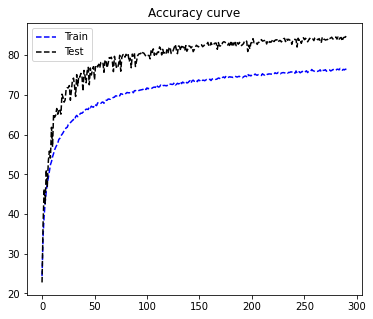

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
style = '--'

ax1.plot(train_acc, style, c='blue', label='Train')
ax1.plot(test_acc, style, c='black', label='Test')

ax1.title.set_text('Accuracy curve')

ax1.legend()

plt.savefig('./plots/metrics.png')

# 87% Accuracy Goal

We continue training once we have achieved our 85% accuracy goal.



In [ ]:
EPOCHS = 5000
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

for epoch in range(EPOCHS):
  
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

  if test_acc[-1] >= 87.0: 
    break 

torch.save(model.state_dict(), './saved_models/model_weights_87.pth')

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6936327815055847 Batch_id=195 Accuracy=76.78: 100%|██████████| 196/196 [00:09<00:00, 21.77it/s]



Test set: Average loss: 0.0019, Accuracy: 8436/10000 (84.36%)

EPOCH: 1


Loss=0.8606456518173218 Batch_id=195 Accuracy=76.24: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]



Test set: Average loss: 0.0018, Accuracy: 8410/10000 (84.10%)

EPOCH: 2


Loss=0.8917449116706848 Batch_id=195 Accuracy=76.58: 100%|██████████| 196/196 [00:08<00:00, 22.15it/s]



Test set: Average loss: 0.0018, Accuracy: 8443/10000 (84.43%)

EPOCH: 3


Loss=0.5299173593521118 Batch_id=195 Accuracy=76.31: 100%|██████████| 196/196 [00:08<00:00, 22.05it/s]



Test set: Average loss: 0.0018, Accuracy: 8395/10000 (83.95%)

EPOCH: 4


Loss=0.611122190952301 Batch_id=195 Accuracy=76.32: 100%|██████████| 196/196 [00:08<00:00, 22.08it/s]



Test set: Average loss: 0.0018, Accuracy: 8426/10000 (84.26%)

EPOCH: 5


Loss=0.5484247803688049 Batch_id=195 Accuracy=76.69: 100%|██████████| 196/196 [00:08<00:00, 22.02it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

EPOCH: 6


Loss=0.6780575513839722 Batch_id=195 Accuracy=76.48: 100%|██████████| 196/196 [00:08<00:00, 22.07it/s]



Test set: Average loss: 0.0018, Accuracy: 8457/10000 (84.57%)

EPOCH: 7


Loss=0.6427725553512573 Batch_id=195 Accuracy=76.88: 100%|██████████| 196/196 [00:08<00:00, 21.81it/s]



Test set: Average loss: 0.0018, Accuracy: 8503/10000 (85.03%)

EPOCH: 8


Loss=0.6465849876403809 Batch_id=195 Accuracy=76.50: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8471/10000 (84.71%)

EPOCH: 9


Loss=0.5154553651809692 Batch_id=195 Accuracy=76.49: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0018, Accuracy: 8428/10000 (84.28%)

EPOCH: 10


Loss=0.9609156847000122 Batch_id=195 Accuracy=76.18: 100%|██████████| 196/196 [00:08<00:00, 21.80it/s]



Test set: Average loss: 0.0018, Accuracy: 8473/10000 (84.73%)

EPOCH: 11


Loss=0.616864800453186 Batch_id=195 Accuracy=77.03: 100%|██████████| 196/196 [00:08<00:00, 22.22it/s]



Test set: Average loss: 0.0018, Accuracy: 8411/10000 (84.11%)

EPOCH: 12


Loss=0.8160346746444702 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:08<00:00, 22.07it/s]



Test set: Average loss: 0.0019, Accuracy: 8431/10000 (84.31%)

EPOCH: 13


Loss=0.756677508354187 Batch_id=195 Accuracy=76.70: 100%|██████████| 196/196 [00:08<00:00, 22.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8441/10000 (84.41%)

EPOCH: 14


Loss=0.885097861289978 Batch_id=195 Accuracy=76.79: 100%|██████████| 196/196 [00:08<00:00, 22.20it/s]



Test set: Average loss: 0.0018, Accuracy: 8470/10000 (84.70%)

EPOCH: 15


Loss=0.48419737815856934 Batch_id=195 Accuracy=76.54: 100%|██████████| 196/196 [00:08<00:00, 21.90it/s]



Test set: Average loss: 0.0019, Accuracy: 8396/10000 (83.96%)

EPOCH: 16


Loss=0.737000048160553 Batch_id=195 Accuracy=76.40: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0018, Accuracy: 8497/10000 (84.97%)

EPOCH: 17


Loss=0.9067156910896301 Batch_id=195 Accuracy=76.75: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0018, Accuracy: 8489/10000 (84.89%)

EPOCH: 18


Loss=0.598962128162384 Batch_id=195 Accuracy=76.68: 100%|██████████| 196/196 [00:08<00:00, 22.15it/s]



Test set: Average loss: 0.0018, Accuracy: 8472/10000 (84.72%)

EPOCH: 19


Loss=0.6494178771972656 Batch_id=195 Accuracy=76.73: 100%|██████████| 196/196 [00:08<00:00, 22.01it/s]



Test set: Average loss: 0.0018, Accuracy: 8463/10000 (84.63%)

EPOCH: 20


Loss=0.7911349534988403 Batch_id=195 Accuracy=76.86: 100%|██████████| 196/196 [00:08<00:00, 22.13it/s]



Test set: Average loss: 0.0019, Accuracy: 8465/10000 (84.65%)

EPOCH: 21


Loss=0.5600526928901672 Batch_id=195 Accuracy=76.36: 100%|██████████| 196/196 [00:08<00:00, 22.18it/s]



Test set: Average loss: 0.0019, Accuracy: 8383/10000 (83.83%)

EPOCH: 22


Loss=0.6734796762466431 Batch_id=195 Accuracy=76.78: 100%|██████████| 196/196 [00:08<00:00, 22.04it/s]



Test set: Average loss: 0.0019, Accuracy: 8387/10000 (83.87%)

EPOCH: 23


Loss=0.6347812414169312 Batch_id=195 Accuracy=76.94: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8490/10000 (84.90%)

EPOCH: 24


Loss=0.8947216272354126 Batch_id=195 Accuracy=76.72: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0018, Accuracy: 8517/10000 (85.17%)

EPOCH: 25


Loss=0.4475558400154114 Batch_id=195 Accuracy=76.77: 100%|██████████| 196/196 [00:08<00:00, 21.90it/s]



Test set: Average loss: 0.0018, Accuracy: 8451/10000 (84.51%)

EPOCH: 26


Loss=0.5536473989486694 Batch_id=195 Accuracy=76.44: 100%|██████████| 196/196 [00:08<00:00, 21.94it/s]



Test set: Average loss: 0.0018, Accuracy: 8478/10000 (84.78%)

EPOCH: 27


Loss=0.74357008934021 Batch_id=195 Accuracy=76.68: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0018, Accuracy: 8465/10000 (84.65%)

EPOCH: 28


Loss=0.7483143210411072 Batch_id=195 Accuracy=76.78: 100%|██████████| 196/196 [00:08<00:00, 21.82it/s]



Test set: Average loss: 0.0019, Accuracy: 8420/10000 (84.20%)

EPOCH: 29


Loss=0.6180287599563599 Batch_id=195 Accuracy=76.99: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0018, Accuracy: 8472/10000 (84.72%)

EPOCH: 30


Loss=0.8812381625175476 Batch_id=195 Accuracy=76.66: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8511/10000 (85.11%)

EPOCH: 31


Loss=0.9076448678970337 Batch_id=195 Accuracy=76.95: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0019, Accuracy: 8436/10000 (84.36%)

EPOCH: 32


Loss=0.9653153419494629 Batch_id=195 Accuracy=76.71: 100%|██████████| 196/196 [00:09<00:00, 21.76it/s]



Test set: Average loss: 0.0018, Accuracy: 8472/10000 (84.72%)

EPOCH: 33


Loss=0.4445136487483978 Batch_id=195 Accuracy=77.10: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0018, Accuracy: 8488/10000 (84.88%)

EPOCH: 34


Loss=0.8572966456413269 Batch_id=195 Accuracy=76.99: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8486/10000 (84.86%)

EPOCH: 35


Loss=0.6066394448280334 Batch_id=195 Accuracy=76.61: 100%|██████████| 196/196 [00:09<00:00, 21.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8439/10000 (84.39%)

EPOCH: 36


Loss=0.6232103705406189 Batch_id=195 Accuracy=76.88: 100%|██████████| 196/196 [00:08<00:00, 21.91it/s]



Test set: Average loss: 0.0019, Accuracy: 8419/10000 (84.19%)

EPOCH: 37


Loss=0.778694212436676 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:09<00:00, 21.76it/s]



Test set: Average loss: 0.0018, Accuracy: 8469/10000 (84.69%)

EPOCH: 38


Loss=0.8966461420059204 Batch_id=195 Accuracy=76.93: 100%|██████████| 196/196 [00:09<00:00, 21.27it/s]



Test set: Average loss: 0.0018, Accuracy: 8491/10000 (84.91%)

EPOCH: 39


Loss=0.681681752204895 Batch_id=195 Accuracy=76.51: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]



Test set: Average loss: 0.0019, Accuracy: 8475/10000 (84.75%)

EPOCH: 40


Loss=0.7710148096084595 Batch_id=195 Accuracy=76.98: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0018, Accuracy: 8461/10000 (84.61%)

EPOCH: 41


Loss=0.7580791115760803 Batch_id=195 Accuracy=77.20: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]



Test set: Average loss: 0.0018, Accuracy: 8424/10000 (84.24%)

EPOCH: 42


Loss=0.6707429885864258 Batch_id=195 Accuracy=76.91: 100%|██████████| 196/196 [00:08<00:00, 21.99it/s]



Test set: Average loss: 0.0018, Accuracy: 8502/10000 (85.02%)

EPOCH: 43


Loss=0.4915972352027893 Batch_id=195 Accuracy=77.00: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8485/10000 (84.85%)

EPOCH: 44


Loss=0.790795624256134 Batch_id=195 Accuracy=77.06: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0017, Accuracy: 8459/10000 (84.59%)

EPOCH: 45


Loss=0.6787470579147339 Batch_id=195 Accuracy=77.15: 100%|██████████| 196/196 [00:08<00:00, 21.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

EPOCH: 46


Loss=0.75108802318573 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0018, Accuracy: 8496/10000 (84.96%)

EPOCH: 47


Loss=0.806292712688446 Batch_id=195 Accuracy=77.09: 100%|██████████| 196/196 [00:09<00:00, 21.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8467/10000 (84.67%)

EPOCH: 48


Loss=0.6528629660606384 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0018, Accuracy: 8439/10000 (84.39%)

EPOCH: 49


Loss=0.5350379347801208 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0017, Accuracy: 8506/10000 (85.06%)

EPOCH: 50


Loss=0.8293164968490601 Batch_id=195 Accuracy=77.12: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8454/10000 (84.54%)

EPOCH: 51


Loss=0.645749032497406 Batch_id=195 Accuracy=76.92: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8485/10000 (84.85%)

EPOCH: 52


Loss=0.44636112451553345 Batch_id=195 Accuracy=77.01: 100%|██████████| 196/196 [00:09<00:00, 21.68it/s]



Test set: Average loss: 0.0018, Accuracy: 8480/10000 (84.80%)

EPOCH: 53


Loss=0.6123332381248474 Batch_id=195 Accuracy=76.99: 100%|██████████| 196/196 [00:09<00:00, 21.41it/s]



Test set: Average loss: 0.0018, Accuracy: 8479/10000 (84.79%)

EPOCH: 54


Loss=0.6731225252151489 Batch_id=195 Accuracy=77.22: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0019, Accuracy: 8410/10000 (84.10%)

EPOCH: 55


Loss=1.0183924436569214 Batch_id=195 Accuracy=76.94: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0018, Accuracy: 8467/10000 (84.67%)

EPOCH: 56


Loss=0.682040810585022 Batch_id=195 Accuracy=77.11: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]



Test set: Average loss: 0.0018, Accuracy: 8501/10000 (85.01%)

EPOCH: 57


Loss=0.4992617964744568 Batch_id=195 Accuracy=77.10: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0017, Accuracy: 8510/10000 (85.10%)

EPOCH: 58


Loss=0.6033452749252319 Batch_id=195 Accuracy=77.33: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8437/10000 (84.37%)

EPOCH: 59


Loss=0.6025899052619934 Batch_id=195 Accuracy=76.72: 100%|██████████| 196/196 [00:09<00:00, 21.66it/s]



Test set: Average loss: 0.0018, Accuracy: 8453/10000 (84.53%)

EPOCH: 60


Loss=0.8732708692550659 Batch_id=195 Accuracy=77.09: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0018, Accuracy: 8520/10000 (85.20%)

EPOCH: 61


Loss=0.9073988199234009 Batch_id=195 Accuracy=76.79: 100%|██████████| 196/196 [00:09<00:00, 21.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8466/10000 (84.66%)

EPOCH: 62


Loss=0.6923279762268066 Batch_id=195 Accuracy=77.09: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0018, Accuracy: 8462/10000 (84.62%)

EPOCH: 63


Loss=0.6396399140357971 Batch_id=195 Accuracy=77.29: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8554/10000 (85.54%)

EPOCH: 64


Loss=0.841748058795929 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0017, Accuracy: 8505/10000 (85.05%)

EPOCH: 65


Loss=0.6402050256729126 Batch_id=195 Accuracy=77.07: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0018, Accuracy: 8454/10000 (84.54%)

EPOCH: 66


Loss=0.5925747156143188 Batch_id=195 Accuracy=77.35: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0017, Accuracy: 8505/10000 (85.05%)

EPOCH: 67


Loss=0.795297384262085 Batch_id=195 Accuracy=77.28: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0018, Accuracy: 8440/10000 (84.40%)

EPOCH: 68


Loss=0.7362546324729919 Batch_id=195 Accuracy=77.10: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s]



Test set: Average loss: 0.0018, Accuracy: 8493/10000 (84.93%)

EPOCH: 69


Loss=0.5633841753005981 Batch_id=195 Accuracy=77.02: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0017, Accuracy: 8509/10000 (85.09%)

EPOCH: 70


Loss=0.7163210511207581 Batch_id=195 Accuracy=77.51: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0018, Accuracy: 8481/10000 (84.81%)

EPOCH: 71


Loss=0.7952044606208801 Batch_id=195 Accuracy=77.12: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0019, Accuracy: 8463/10000 (84.63%)

EPOCH: 72


Loss=0.7381523847579956 Batch_id=195 Accuracy=77.42: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0017, Accuracy: 8469/10000 (84.69%)

EPOCH: 73


Loss=0.5796023011207581 Batch_id=195 Accuracy=77.40: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0018, Accuracy: 8441/10000 (84.41%)

EPOCH: 74


Loss=0.6661249399185181 Batch_id=195 Accuracy=77.08: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0018, Accuracy: 8463/10000 (84.63%)

EPOCH: 75


Loss=0.6993392109870911 Batch_id=195 Accuracy=76.90: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0018, Accuracy: 8525/10000 (85.25%)

EPOCH: 76


Loss=0.8049918413162231 Batch_id=195 Accuracy=77.43: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0017, Accuracy: 8506/10000 (85.06%)

EPOCH: 77


Loss=0.8306767344474792 Batch_id=195 Accuracy=77.24: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0017, Accuracy: 8536/10000 (85.36%)

EPOCH: 78


Loss=0.662182092666626 Batch_id=195 Accuracy=77.43: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0018, Accuracy: 8449/10000 (84.49%)

EPOCH: 79


Loss=0.7687662839889526 Batch_id=195 Accuracy=77.25: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8527/10000 (85.27%)

EPOCH: 80


Loss=0.7475970387458801 Batch_id=195 Accuracy=77.21: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0018, Accuracy: 8476/10000 (84.76%)

EPOCH: 81


Loss=0.6991826295852661 Batch_id=195 Accuracy=77.19: 100%|██████████| 196/196 [00:09<00:00, 21.39it/s]



Test set: Average loss: 0.0017, Accuracy: 8507/10000 (85.07%)

EPOCH: 82


Loss=0.5695565938949585 Batch_id=195 Accuracy=77.27: 100%|██████████| 196/196 [00:09<00:00, 21.66it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 83


Loss=0.7379744052886963 Batch_id=195 Accuracy=77.51: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0018, Accuracy: 8522/10000 (85.22%)

EPOCH: 84


Loss=0.6893571615219116 Batch_id=195 Accuracy=77.33: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]



Test set: Average loss: 0.0017, Accuracy: 8516/10000 (85.16%)

EPOCH: 85


Loss=0.6112107634544373 Batch_id=195 Accuracy=77.38: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0017, Accuracy: 8537/10000 (85.37%)

EPOCH: 86


Loss=0.6906188726425171 Batch_id=195 Accuracy=77.46: 100%|██████████| 196/196 [00:09<00:00, 21.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8476/10000 (84.76%)

EPOCH: 87


Loss=0.5009800791740417 Batch_id=195 Accuracy=77.63: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0018, Accuracy: 8492/10000 (84.92%)

EPOCH: 88


Loss=0.59508216381073 Batch_id=195 Accuracy=77.69: 100%|██████████| 196/196 [00:09<00:00, 21.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8470/10000 (84.70%)

EPOCH: 89


Loss=0.5826046466827393 Batch_id=195 Accuracy=77.46: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0017, Accuracy: 8509/10000 (85.09%)

EPOCH: 90


Loss=0.8596181869506836 Batch_id=195 Accuracy=77.47: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0017, Accuracy: 8498/10000 (84.98%)

EPOCH: 91


Loss=0.9458475112915039 Batch_id=195 Accuracy=77.62: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0018, Accuracy: 8477/10000 (84.77%)

EPOCH: 92


Loss=0.5314751863479614 Batch_id=195 Accuracy=77.72: 100%|██████████| 196/196 [00:09<00:00, 20.54it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

EPOCH: 93


Loss=0.8211905360221863 Batch_id=195 Accuracy=77.42: 100%|██████████| 196/196 [00:09<00:00, 20.45it/s]



Test set: Average loss: 0.0017, Accuracy: 8506/10000 (85.06%)

EPOCH: 94


Loss=0.4846727252006531 Batch_id=195 Accuracy=77.25: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0018, Accuracy: 8452/10000 (84.52%)

EPOCH: 95


Loss=0.6079312562942505 Batch_id=195 Accuracy=77.28: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0018, Accuracy: 8465/10000 (84.65%)

EPOCH: 96


Loss=0.6783595681190491 Batch_id=195 Accuracy=77.38: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0018, Accuracy: 8498/10000 (84.98%)

EPOCH: 97


Loss=0.4970772862434387 Batch_id=195 Accuracy=77.32: 100%|██████████| 196/196 [00:09<00:00, 21.11it/s]



Test set: Average loss: 0.0017, Accuracy: 8520/10000 (85.20%)

EPOCH: 98


Loss=0.6868667006492615 Batch_id=195 Accuracy=77.40: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]



Test set: Average loss: 0.0018, Accuracy: 8507/10000 (85.07%)

EPOCH: 99


Loss=0.619513750076294 Batch_id=195 Accuracy=77.64: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0018, Accuracy: 8519/10000 (85.19%)

EPOCH: 100


Loss=0.5679833889007568 Batch_id=195 Accuracy=77.75: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0018, Accuracy: 8472/10000 (84.72%)

EPOCH: 101


Loss=0.7129364609718323 Batch_id=195 Accuracy=77.61: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0017, Accuracy: 8503/10000 (85.03%)

EPOCH: 102


Loss=0.6973605751991272 Batch_id=195 Accuracy=77.41: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0017, Accuracy: 8531/10000 (85.31%)

EPOCH: 103


Loss=0.7356324195861816 Batch_id=195 Accuracy=77.77: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0018, Accuracy: 8477/10000 (84.77%)

EPOCH: 104


Loss=0.5061683654785156 Batch_id=195 Accuracy=78.01: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0017, Accuracy: 8509/10000 (85.09%)

EPOCH: 105


Loss=0.6553341150283813 Batch_id=195 Accuracy=77.34: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0017, Accuracy: 8529/10000 (85.29%)

EPOCH: 106


Loss=0.6523209810256958 Batch_id=195 Accuracy=77.63: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0017, Accuracy: 8521/10000 (85.21%)

EPOCH: 107


Loss=0.5692057013511658 Batch_id=195 Accuracy=77.51: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8533/10000 (85.33%)

EPOCH: 108


Loss=0.61210036277771 Batch_id=195 Accuracy=77.56: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8506/10000 (85.06%)

EPOCH: 109


Loss=0.5410773754119873 Batch_id=195 Accuracy=77.85: 100%|██████████| 196/196 [00:09<00:00, 21.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8472/10000 (84.72%)

EPOCH: 110


Loss=0.7755278944969177 Batch_id=195 Accuracy=77.55: 100%|██████████| 196/196 [00:09<00:00, 21.27it/s]



Test set: Average loss: 0.0018, Accuracy: 8506/10000 (85.06%)

EPOCH: 111


Loss=0.855457603931427 Batch_id=195 Accuracy=77.62: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0017, Accuracy: 8527/10000 (85.27%)

EPOCH: 112


Loss=0.5455340147018433 Batch_id=195 Accuracy=77.66: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0018, Accuracy: 8525/10000 (85.25%)

EPOCH: 113


Loss=0.4301009774208069 Batch_id=195 Accuracy=77.88: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0017, Accuracy: 8548/10000 (85.48%)

EPOCH: 114


Loss=0.8881031274795532 Batch_id=195 Accuracy=77.69: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 115


Loss=0.5789924263954163 Batch_id=195 Accuracy=77.74: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 116


Loss=0.5465649366378784 Batch_id=195 Accuracy=77.57: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0017, Accuracy: 8523/10000 (85.23%)

EPOCH: 117


Loss=0.7234767079353333 Batch_id=195 Accuracy=77.70: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0017, Accuracy: 8521/10000 (85.21%)

EPOCH: 118


Loss=0.5223787426948547 Batch_id=195 Accuracy=77.61: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 119


Loss=0.6215022802352905 Batch_id=195 Accuracy=77.64: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0017, Accuracy: 8541/10000 (85.41%)

EPOCH: 120


Loss=0.5228745937347412 Batch_id=195 Accuracy=77.81: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8554/10000 (85.54%)

EPOCH: 121


Loss=0.7759358882904053 Batch_id=195 Accuracy=77.78: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0018, Accuracy: 8492/10000 (84.92%)

EPOCH: 122


Loss=0.45317792892456055 Batch_id=195 Accuracy=77.79: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0018, Accuracy: 8511/10000 (85.11%)

EPOCH: 123


Loss=0.7385382056236267 Batch_id=195 Accuracy=77.94: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8523/10000 (85.23%)

EPOCH: 124


Loss=0.7323115468025208 Batch_id=195 Accuracy=77.73: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0017, Accuracy: 8533/10000 (85.33%)

EPOCH: 125


Loss=0.7390485405921936 Batch_id=195 Accuracy=77.49: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 126


Loss=0.6989163756370544 Batch_id=195 Accuracy=77.77: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0017, Accuracy: 8522/10000 (85.22%)

EPOCH: 127


Loss=0.5348355174064636 Batch_id=195 Accuracy=77.72: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8526/10000 (85.26%)

EPOCH: 128


Loss=0.7005593776702881 Batch_id=195 Accuracy=77.96: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0017, Accuracy: 8534/10000 (85.34%)

EPOCH: 129


Loss=0.5688188672065735 Batch_id=195 Accuracy=77.54: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0017, Accuracy: 8515/10000 (85.15%)

EPOCH: 130


Loss=0.6185675263404846 Batch_id=195 Accuracy=77.76: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8554/10000 (85.54%)

EPOCH: 131


Loss=0.6204320788383484 Batch_id=195 Accuracy=78.01: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8476/10000 (84.76%)

EPOCH: 132


Loss=0.4367862343788147 Batch_id=195 Accuracy=77.64: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8516/10000 (85.16%)

EPOCH: 133


Loss=0.8137249946594238 Batch_id=195 Accuracy=77.57: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 134


Loss=0.7159982919692993 Batch_id=195 Accuracy=77.62: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0017, Accuracy: 8531/10000 (85.31%)

EPOCH: 135


Loss=0.7170776128768921 Batch_id=195 Accuracy=77.85: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 136


Loss=0.4962463974952698 Batch_id=195 Accuracy=77.78: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0017, Accuracy: 8527/10000 (85.27%)

EPOCH: 137


Loss=0.5582712888717651 Batch_id=195 Accuracy=78.00: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0018, Accuracy: 8504/10000 (85.04%)

EPOCH: 138


Loss=0.6388319134712219 Batch_id=195 Accuracy=78.03: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8561/10000 (85.61%)

EPOCH: 139


Loss=0.45780548453330994 Batch_id=195 Accuracy=77.90: 100%|██████████| 196/196 [00:09<00:00, 21.41it/s]



Test set: Average loss: 0.0017, Accuracy: 8510/10000 (85.10%)

EPOCH: 140


Loss=0.7379004955291748 Batch_id=195 Accuracy=77.86: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8517/10000 (85.17%)

EPOCH: 141


Loss=0.6098461151123047 Batch_id=195 Accuracy=78.04: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 142


Loss=0.6696270108222961 Batch_id=195 Accuracy=77.99: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 143


Loss=0.6276935338973999 Batch_id=195 Accuracy=77.78: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0018, Accuracy: 8491/10000 (84.91%)

EPOCH: 144


Loss=0.7015961408615112 Batch_id=195 Accuracy=77.86: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 145


Loss=0.5674805641174316 Batch_id=195 Accuracy=77.85: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8553/10000 (85.53%)

EPOCH: 146


Loss=0.7234431505203247 Batch_id=195 Accuracy=77.63: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0017, Accuracy: 8555/10000 (85.55%)

EPOCH: 147


Loss=0.572498083114624 Batch_id=195 Accuracy=77.76: 100%|██████████| 196/196 [00:09<00:00, 20.92it/s]



Test set: Average loss: 0.0017, Accuracy: 8530/10000 (85.30%)

EPOCH: 148


Loss=0.7541826367378235 Batch_id=195 Accuracy=77.96: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8529/10000 (85.29%)

EPOCH: 149


Loss=0.4667445719242096 Batch_id=195 Accuracy=77.82: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0017, Accuracy: 8566/10000 (85.66%)

EPOCH: 150


Loss=0.7620651721954346 Batch_id=195 Accuracy=77.97: 100%|██████████| 196/196 [00:09<00:00, 20.97it/s]



Test set: Average loss: 0.0017, Accuracy: 8544/10000 (85.44%)

EPOCH: 151


Loss=0.4552927613258362 Batch_id=195 Accuracy=77.92: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0017, Accuracy: 8547/10000 (85.47%)

EPOCH: 152


Loss=0.717284083366394 Batch_id=195 Accuracy=77.90: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0017, Accuracy: 8574/10000 (85.74%)

EPOCH: 153


Loss=0.6652184724807739 Batch_id=195 Accuracy=78.11: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0018, Accuracy: 8509/10000 (85.09%)

EPOCH: 154


Loss=0.6149833798408508 Batch_id=195 Accuracy=77.98: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0017, Accuracy: 8551/10000 (85.51%)

EPOCH: 155


Loss=0.6660968065261841 Batch_id=195 Accuracy=77.90: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0017, Accuracy: 8565/10000 (85.65%)

EPOCH: 156


Loss=0.9161443710327148 Batch_id=195 Accuracy=78.04: 100%|██████████| 196/196 [00:09<00:00, 20.92it/s]



Test set: Average loss: 0.0017, Accuracy: 8527/10000 (85.27%)

EPOCH: 157


Loss=0.6067260503768921 Batch_id=195 Accuracy=77.90: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

EPOCH: 158


Loss=0.7843418121337891 Batch_id=195 Accuracy=78.06: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8609/10000 (86.09%)

EPOCH: 159


Loss=0.6586620211601257 Batch_id=195 Accuracy=78.01: 100%|██████████| 196/196 [00:09<00:00, 20.97it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 160


Loss=0.5767245888710022 Batch_id=195 Accuracy=78.23: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 161


Loss=0.7918301224708557 Batch_id=195 Accuracy=78.16: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0017, Accuracy: 8488/10000 (84.88%)

EPOCH: 162


Loss=0.6796271204948425 Batch_id=195 Accuracy=78.07: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0020, Accuracy: 8366/10000 (83.66%)

EPOCH: 163


Loss=0.6613256931304932 Batch_id=195 Accuracy=78.08: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8502/10000 (85.02%)

EPOCH: 164


Loss=0.5125905871391296 Batch_id=195 Accuracy=78.12: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8561/10000 (85.61%)

EPOCH: 165


Loss=0.6476315259933472 Batch_id=195 Accuracy=77.85: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0017, Accuracy: 8512/10000 (85.12%)

EPOCH: 166


Loss=0.547027051448822 Batch_id=195 Accuracy=78.14: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 167


Loss=0.7900601029396057 Batch_id=195 Accuracy=78.05: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0017, Accuracy: 8533/10000 (85.33%)

EPOCH: 168


Loss=0.6271438002586365 Batch_id=195 Accuracy=78.15: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]



Test set: Average loss: 0.0017, Accuracy: 8535/10000 (85.35%)

EPOCH: 169


Loss=0.7578689455986023 Batch_id=195 Accuracy=77.90: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0017, Accuracy: 8590/10000 (85.90%)

EPOCH: 170


Loss=0.6887487173080444 Batch_id=195 Accuracy=78.02: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0017, Accuracy: 8550/10000 (85.50%)

EPOCH: 171


Loss=0.551051139831543 Batch_id=195 Accuracy=78.18: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 172


Loss=0.5183945298194885 Batch_id=195 Accuracy=77.79: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0016, Accuracy: 8570/10000 (85.70%)

EPOCH: 173


Loss=0.7490902543067932 Batch_id=195 Accuracy=78.22: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0017, Accuracy: 8517/10000 (85.17%)

EPOCH: 174


Loss=0.7552849650382996 Batch_id=195 Accuracy=77.93: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 175


Loss=0.6493144631385803 Batch_id=195 Accuracy=77.88: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8569/10000 (85.69%)

EPOCH: 176


Loss=0.7619073390960693 Batch_id=195 Accuracy=78.12: 100%|██████████| 196/196 [00:09<00:00, 20.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 177


Loss=0.7459508180618286 Batch_id=195 Accuracy=78.01: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8532/10000 (85.32%)

EPOCH: 178


Loss=0.5420181155204773 Batch_id=195 Accuracy=78.15: 100%|██████████| 196/196 [00:09<00:00, 21.12it/s]



Test set: Average loss: 0.0017, Accuracy: 8538/10000 (85.38%)

EPOCH: 179


Loss=0.5670574903488159 Batch_id=195 Accuracy=78.42: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

EPOCH: 180


Loss=0.4701496958732605 Batch_id=195 Accuracy=78.49: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8562/10000 (85.62%)

EPOCH: 181


Loss=0.5768638253211975 Batch_id=195 Accuracy=78.27: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0017, Accuracy: 8538/10000 (85.38%)

EPOCH: 182


Loss=0.7899361252784729 Batch_id=195 Accuracy=78.46: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0018, Accuracy: 8480/10000 (84.80%)

EPOCH: 183


Loss=0.7351246476173401 Batch_id=195 Accuracy=78.29: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 184


Loss=0.4931734502315521 Batch_id=195 Accuracy=78.60: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 185


Loss=0.6574708223342896 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]



Test set: Average loss: 0.0017, Accuracy: 8555/10000 (85.55%)

EPOCH: 186


Loss=0.6119529008865356 Batch_id=195 Accuracy=78.34: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]



Test set: Average loss: 0.0017, Accuracy: 8529/10000 (85.29%)

EPOCH: 187


Loss=0.5795071721076965 Batch_id=195 Accuracy=78.41: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0017, Accuracy: 8550/10000 (85.50%)

EPOCH: 188


Loss=0.5588116645812988 Batch_id=195 Accuracy=78.27: 100%|██████████| 196/196 [00:09<00:00, 20.82it/s]



Test set: Average loss: 0.0017, Accuracy: 8535/10000 (85.35%)

EPOCH: 189


Loss=0.6067143678665161 Batch_id=195 Accuracy=78.35: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0016, Accuracy: 8594/10000 (85.94%)

EPOCH: 190


Loss=0.6411874294281006 Batch_id=195 Accuracy=78.62: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0017, Accuracy: 8533/10000 (85.33%)

EPOCH: 191


Loss=0.8345414996147156 Batch_id=195 Accuracy=78.20: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8568/10000 (85.68%)

EPOCH: 192


Loss=0.46103978157043457 Batch_id=195 Accuracy=78.37: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]



Test set: Average loss: 0.0017, Accuracy: 8575/10000 (85.75%)

EPOCH: 193


Loss=0.8692023158073425 Batch_id=195 Accuracy=78.64: 100%|██████████| 196/196 [00:09<00:00, 21.00it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 194


Loss=0.5704764723777771 Batch_id=195 Accuracy=78.49: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0017, Accuracy: 8563/10000 (85.63%)

EPOCH: 195


Loss=0.6125621199607849 Batch_id=195 Accuracy=78.28: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]



Test set: Average loss: 0.0017, Accuracy: 8554/10000 (85.54%)

EPOCH: 196


Loss=0.6031957864761353 Batch_id=195 Accuracy=78.22: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0018, Accuracy: 8517/10000 (85.17%)

EPOCH: 197


Loss=0.7653792500495911 Batch_id=195 Accuracy=78.43: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0017, Accuracy: 8565/10000 (85.65%)

EPOCH: 198


Loss=0.5777368545532227 Batch_id=195 Accuracy=78.27: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0017, Accuracy: 8585/10000 (85.85%)

EPOCH: 199


Loss=0.6925040483474731 Batch_id=195 Accuracy=78.52: 100%|██████████| 196/196 [00:09<00:00, 20.68it/s]



Test set: Average loss: 0.0017, Accuracy: 8593/10000 (85.93%)

EPOCH: 200


Loss=0.7473233938217163 Batch_id=195 Accuracy=78.46: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0017, Accuracy: 8558/10000 (85.58%)

EPOCH: 201


Loss=0.4920656681060791 Batch_id=195 Accuracy=78.30: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0017, Accuracy: 8561/10000 (85.61%)

EPOCH: 202


Loss=0.6062949299812317 Batch_id=195 Accuracy=78.21: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0017, Accuracy: 8536/10000 (85.36%)

EPOCH: 203


Loss=0.6582255363464355 Batch_id=195 Accuracy=78.45: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 204


Loss=0.6005308628082275 Batch_id=195 Accuracy=78.62: 100%|██████████| 196/196 [00:09<00:00, 20.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 205


Loss=0.8560455441474915 Batch_id=195 Accuracy=78.36: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s]



Test set: Average loss: 0.0017, Accuracy: 8558/10000 (85.58%)

EPOCH: 206


Loss=0.5646756887435913 Batch_id=195 Accuracy=78.35: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8566/10000 (85.66%)

EPOCH: 207


Loss=0.6305145025253296 Batch_id=195 Accuracy=78.29: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0017, Accuracy: 8557/10000 (85.57%)

EPOCH: 208


Loss=0.6660057902336121 Batch_id=195 Accuracy=78.45: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 209


Loss=0.5848320126533508 Batch_id=195 Accuracy=78.53: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0017, Accuracy: 8574/10000 (85.74%)

EPOCH: 210


Loss=0.7177454233169556 Batch_id=195 Accuracy=78.48: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8587/10000 (85.87%)

EPOCH: 211


Loss=0.8512288928031921 Batch_id=195 Accuracy=78.32: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0017, Accuracy: 8609/10000 (86.09%)

EPOCH: 212


Loss=0.6548194885253906 Batch_id=195 Accuracy=78.53: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 213


Loss=0.5185920000076294 Batch_id=195 Accuracy=78.70: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

EPOCH: 214


Loss=0.4722382128238678 Batch_id=195 Accuracy=78.56: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8600/10000 (86.00%)

EPOCH: 215


Loss=0.5800628662109375 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 20.35it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 216


Loss=0.814022421836853 Batch_id=195 Accuracy=78.50: 100%|██████████| 196/196 [00:09<00:00, 20.08it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 217


Loss=0.6937538385391235 Batch_id=195 Accuracy=78.24: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]



Test set: Average loss: 0.0016, Accuracy: 8591/10000 (85.91%)

EPOCH: 218


Loss=0.4662511944770813 Batch_id=195 Accuracy=78.45: 100%|██████████| 196/196 [00:09<00:00, 20.40it/s]



Test set: Average loss: 0.0017, Accuracy: 8594/10000 (85.94%)

EPOCH: 219


Loss=0.6630833745002747 Batch_id=195 Accuracy=78.50: 100%|██████████| 196/196 [00:09<00:00, 20.47it/s]



Test set: Average loss: 0.0017, Accuracy: 8596/10000 (85.96%)

EPOCH: 220


Loss=0.49295535683631897 Batch_id=195 Accuracy=78.47: 100%|██████████| 196/196 [00:09<00:00, 20.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8578/10000 (85.78%)

EPOCH: 221


Loss=0.6427336931228638 Batch_id=195 Accuracy=78.44: 100%|██████████| 196/196 [00:09<00:00, 20.10it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 222


Loss=0.5421187877655029 Batch_id=195 Accuracy=78.63: 100%|██████████| 196/196 [00:09<00:00, 20.21it/s]



Test set: Average loss: 0.0016, Accuracy: 8591/10000 (85.91%)

EPOCH: 223


Loss=0.6582150459289551 Batch_id=195 Accuracy=78.51: 100%|██████████| 196/196 [00:09<00:00, 20.46it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 224


Loss=0.5462473630905151 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 20.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8560/10000 (85.60%)

EPOCH: 225


Loss=0.8232972025871277 Batch_id=195 Accuracy=78.51: 100%|██████████| 196/196 [00:09<00:00, 20.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8590/10000 (85.90%)

EPOCH: 226


Loss=0.6295438408851624 Batch_id=195 Accuracy=78.34: 100%|██████████| 196/196 [00:09<00:00, 20.14it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 227


Loss=0.6077440977096558 Batch_id=195 Accuracy=78.42: 100%|██████████| 196/196 [00:09<00:00, 20.43it/s]



Test set: Average loss: 0.0018, Accuracy: 8488/10000 (84.88%)

EPOCH: 228


Loss=0.5582035183906555 Batch_id=195 Accuracy=78.58: 100%|██████████| 196/196 [00:09<00:00, 20.22it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 229


Loss=0.6004014015197754 Batch_id=195 Accuracy=78.53: 100%|██████████| 196/196 [00:09<00:00, 20.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8591/10000 (85.91%)

EPOCH: 230


Loss=0.546942949295044 Batch_id=195 Accuracy=78.64: 100%|██████████| 196/196 [00:09<00:00, 20.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8604/10000 (86.04%)

EPOCH: 231


Loss=0.6995522379875183 Batch_id=195 Accuracy=78.78: 100%|██████████| 196/196 [00:09<00:00, 20.48it/s]



Test set: Average loss: 0.0017, Accuracy: 8555/10000 (85.55%)

EPOCH: 232


Loss=0.47628435492515564 Batch_id=195 Accuracy=78.38: 100%|██████████| 196/196 [00:09<00:00, 20.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 233


Loss=0.4916137754917145 Batch_id=195 Accuracy=78.72: 100%|██████████| 196/196 [00:09<00:00, 20.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8566/10000 (85.66%)

EPOCH: 234


Loss=0.7923356294631958 Batch_id=195 Accuracy=78.59: 100%|██████████| 196/196 [00:09<00:00, 20.37it/s]



Test set: Average loss: 0.0017, Accuracy: 8583/10000 (85.83%)

EPOCH: 235


Loss=0.6865409016609192 Batch_id=195 Accuracy=78.43: 100%|██████████| 196/196 [00:09<00:00, 20.21it/s]



Test set: Average loss: 0.0016, Accuracy: 8587/10000 (85.87%)

EPOCH: 236


Loss=0.9007278680801392 Batch_id=195 Accuracy=78.54: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8587/10000 (85.87%)

EPOCH: 237


Loss=0.6122448444366455 Batch_id=195 Accuracy=78.66: 100%|██████████| 196/196 [00:09<00:00, 20.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8525/10000 (85.25%)

EPOCH: 238


Loss=0.45527759194374084 Batch_id=195 Accuracy=78.85: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0017, Accuracy: 8571/10000 (85.71%)

EPOCH: 239


Loss=0.5604280233383179 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 20.18it/s]



Test set: Average loss: 0.0017, Accuracy: 8600/10000 (86.00%)

EPOCH: 240


Loss=0.653473436832428 Batch_id=195 Accuracy=78.24: 100%|██████████| 196/196 [00:09<00:00, 20.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8582/10000 (85.82%)

EPOCH: 241


Loss=0.6640099883079529 Batch_id=195 Accuracy=78.73: 100%|██████████| 196/196 [00:09<00:00, 20.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8593/10000 (85.93%)

EPOCH: 242


Loss=0.6545994281768799 Batch_id=195 Accuracy=78.72: 100%|██████████| 196/196 [00:09<00:00, 20.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8598/10000 (85.98%)

EPOCH: 243


Loss=0.9341567158699036 Batch_id=195 Accuracy=78.57: 100%|██████████| 196/196 [00:09<00:00, 20.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8558/10000 (85.58%)

EPOCH: 244


Loss=0.6733912229537964 Batch_id=195 Accuracy=78.53: 100%|██████████| 196/196 [00:09<00:00, 20.22it/s]



Test set: Average loss: 0.0017, Accuracy: 8565/10000 (85.65%)

EPOCH: 245


Loss=0.6514401435852051 Batch_id=195 Accuracy=78.90: 100%|██████████| 196/196 [00:09<00:00, 20.18it/s]



Test set: Average loss: 0.0016, Accuracy: 8582/10000 (85.82%)

EPOCH: 246


Loss=0.6788161396980286 Batch_id=195 Accuracy=78.77: 100%|██████████| 196/196 [00:09<00:00, 20.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8557/10000 (85.57%)

EPOCH: 247


Loss=0.6258678436279297 Batch_id=195 Accuracy=78.57: 100%|██████████| 196/196 [00:09<00:00, 20.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8578/10000 (85.78%)

EPOCH: 248


Loss=0.800554633140564 Batch_id=195 Accuracy=78.41: 100%|██████████| 196/196 [00:09<00:00, 20.03it/s]



Test set: Average loss: 0.0016, Accuracy: 8594/10000 (85.94%)

EPOCH: 249


Loss=0.5935038328170776 Batch_id=195 Accuracy=78.68: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0017, Accuracy: 8612/10000 (86.12%)

EPOCH: 250


Loss=0.5515622496604919 Batch_id=195 Accuracy=78.96: 100%|██████████| 196/196 [00:09<00:00, 19.89it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 251


Loss=0.5671284198760986 Batch_id=195 Accuracy=78.77: 100%|██████████| 196/196 [00:09<00:00, 19.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 252


Loss=0.512346088886261 Batch_id=195 Accuracy=78.79: 100%|██████████| 196/196 [00:09<00:00, 20.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8577/10000 (85.77%)

EPOCH: 253


Loss=0.6746441721916199 Batch_id=195 Accuracy=78.47: 100%|██████████| 196/196 [00:09<00:00, 20.23it/s]



Test set: Average loss: 0.0017, Accuracy: 8485/10000 (84.85%)

EPOCH: 254


Loss=0.7143003940582275 Batch_id=195 Accuracy=78.36: 100%|██████████| 196/196 [00:09<00:00, 20.14it/s]



Test set: Average loss: 0.0016, Accuracy: 8578/10000 (85.78%)

EPOCH: 255


Loss=0.639184296131134 Batch_id=195 Accuracy=78.93: 100%|██████████| 196/196 [00:09<00:00, 20.34it/s]



Test set: Average loss: 0.0016, Accuracy: 8584/10000 (85.84%)

EPOCH: 256


Loss=0.7366243600845337 Batch_id=195 Accuracy=79.15: 100%|██████████| 196/196 [00:09<00:00, 20.16it/s]



Test set: Average loss: 0.0016, Accuracy: 8628/10000 (86.28%)

EPOCH: 257


Loss=0.5925573706626892 Batch_id=195 Accuracy=78.72: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 258


Loss=0.6474029421806335 Batch_id=195 Accuracy=78.65: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]



Test set: Average loss: 0.0017, Accuracy: 8576/10000 (85.76%)

EPOCH: 259


Loss=0.7035855650901794 Batch_id=195 Accuracy=78.67: 100%|██████████| 196/196 [00:09<00:00, 20.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8608/10000 (86.08%)

EPOCH: 260


Loss=0.6417426466941833 Batch_id=195 Accuracy=78.48: 100%|██████████| 196/196 [00:09<00:00, 20.15it/s]



Test set: Average loss: 0.0017, Accuracy: 8603/10000 (86.03%)

EPOCH: 261


Loss=0.8180167078971863 Batch_id=195 Accuracy=78.56: 100%|██████████| 196/196 [00:09<00:00, 20.14it/s]



Test set: Average loss: 0.0017, Accuracy: 8580/10000 (85.80%)

EPOCH: 262


Loss=0.5735183954238892 Batch_id=195 Accuracy=78.69: 100%|██████████| 196/196 [00:09<00:00, 20.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8529/10000 (85.29%)

EPOCH: 263


Loss=0.7400838136672974 Batch_id=195 Accuracy=78.98: 100%|██████████| 196/196 [00:09<00:00, 19.86it/s]



Test set: Average loss: 0.0017, Accuracy: 8569/10000 (85.69%)

EPOCH: 264


Loss=0.5716012716293335 Batch_id=195 Accuracy=78.66: 100%|██████████| 196/196 [00:09<00:00, 20.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8573/10000 (85.73%)

EPOCH: 265


Loss=0.6643146872520447 Batch_id=195 Accuracy=78.86: 100%|██████████| 196/196 [00:09<00:00, 19.87it/s]



Test set: Average loss: 0.0017, Accuracy: 8581/10000 (85.81%)

EPOCH: 266


Loss=0.4531499743461609 Batch_id=195 Accuracy=78.85: 100%|██████████| 196/196 [00:09<00:00, 20.12it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 267


Loss=0.8520879745483398 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 19.97it/s]



Test set: Average loss: 0.0016, Accuracy: 8577/10000 (85.77%)

EPOCH: 268


Loss=0.5649141669273376 Batch_id=195 Accuracy=78.84: 100%|██████████| 196/196 [00:09<00:00, 20.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

EPOCH: 269


Loss=0.680344820022583 Batch_id=195 Accuracy=78.78: 100%|██████████| 196/196 [00:09<00:00, 20.08it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 270


Loss=0.4800470471382141 Batch_id=195 Accuracy=79.03: 100%|██████████| 196/196 [00:09<00:00, 20.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8582/10000 (85.82%)

EPOCH: 271


Loss=0.5650526285171509 Batch_id=195 Accuracy=78.96: 100%|██████████| 196/196 [00:09<00:00, 20.31it/s]



Test set: Average loss: 0.0017, Accuracy: 8578/10000 (85.78%)

EPOCH: 272


Loss=0.7135741114616394 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 19.99it/s]



Test set: Average loss: 0.0017, Accuracy: 8587/10000 (85.87%)

EPOCH: 273


Loss=0.7774449586868286 Batch_id=195 Accuracy=78.93: 100%|██████████| 196/196 [00:09<00:00, 20.28it/s]



Test set: Average loss: 0.0016, Accuracy: 8605/10000 (86.05%)

EPOCH: 274


Loss=0.5448276400566101 Batch_id=195 Accuracy=78.88: 100%|██████████| 196/196 [00:09<00:00, 20.06it/s]



Test set: Average loss: 0.0016, Accuracy: 8579/10000 (85.79%)

EPOCH: 275


Loss=0.5321592092514038 Batch_id=195 Accuracy=78.88: 100%|██████████| 196/196 [00:09<00:00, 20.02it/s]



Test set: Average loss: 0.0017, Accuracy: 8557/10000 (85.57%)

EPOCH: 276


Loss=0.7007167935371399 Batch_id=195 Accuracy=78.63: 100%|██████████| 196/196 [00:09<00:00, 20.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8604/10000 (86.04%)

EPOCH: 277


Loss=0.56655353307724 Batch_id=195 Accuracy=79.23: 100%|██████████| 196/196 [00:09<00:00, 20.23it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 278


Loss=0.537781834602356 Batch_id=195 Accuracy=78.73: 100%|██████████| 196/196 [00:09<00:00, 19.92it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 279


Loss=0.7735922932624817 Batch_id=195 Accuracy=78.85: 100%|██████████| 196/196 [00:09<00:00, 19.96it/s]



Test set: Average loss: 0.0017, Accuracy: 8582/10000 (85.82%)

EPOCH: 280


Loss=0.7217385768890381 Batch_id=195 Accuracy=79.04: 100%|██████████| 196/196 [00:09<00:00, 20.07it/s]



Test set: Average loss: 0.0017, Accuracy: 8574/10000 (85.74%)

EPOCH: 281


Loss=0.6487840414047241 Batch_id=195 Accuracy=78.99: 100%|██████████| 196/196 [00:09<00:00, 20.10it/s]



Test set: Average loss: 0.0017, Accuracy: 8574/10000 (85.74%)

EPOCH: 282


Loss=0.5874864459037781 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 20.09it/s]



Test set: Average loss: 0.0017, Accuracy: 8613/10000 (86.13%)

EPOCH: 283


Loss=0.5276992321014404 Batch_id=195 Accuracy=79.18: 100%|██████████| 196/196 [00:09<00:00, 20.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8593/10000 (85.93%)

EPOCH: 284


Loss=0.8212187886238098 Batch_id=195 Accuracy=79.04: 100%|██████████| 196/196 [00:09<00:00, 20.12it/s]



Test set: Average loss: 0.0018, Accuracy: 8518/10000 (85.18%)

EPOCH: 285


Loss=0.8022931814193726 Batch_id=195 Accuracy=79.18: 100%|██████████| 196/196 [00:09<00:00, 20.03it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 286


Loss=0.6022868156433105 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 20.07it/s]



Test set: Average loss: 0.0017, Accuracy: 8623/10000 (86.23%)

EPOCH: 287


Loss=0.8302438855171204 Batch_id=195 Accuracy=78.88: 100%|██████████| 196/196 [00:09<00:00, 19.98it/s]



Test set: Average loss: 0.0017, Accuracy: 8601/10000 (86.01%)

EPOCH: 288


Loss=0.5681328773498535 Batch_id=195 Accuracy=78.79: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8586/10000 (85.86%)

EPOCH: 289


Loss=0.6259518265724182 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8558/10000 (85.58%)

EPOCH: 290


Loss=0.6893557906150818 Batch_id=195 Accuracy=79.07: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8604/10000 (86.04%)

EPOCH: 291


Loss=0.6245646476745605 Batch_id=195 Accuracy=79.02: 100%|██████████| 196/196 [00:09<00:00, 19.84it/s]



Test set: Average loss: 0.0016, Accuracy: 8591/10000 (85.91%)

EPOCH: 292


Loss=0.8205158114433289 Batch_id=195 Accuracy=78.85: 100%|██████████| 196/196 [00:09<00:00, 20.00it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 293


Loss=0.37434452772140503 Batch_id=195 Accuracy=78.99: 100%|██████████| 196/196 [00:09<00:00, 20.18it/s]



Test set: Average loss: 0.0017, Accuracy: 8596/10000 (85.96%)

EPOCH: 294


Loss=0.7236339449882507 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 295


Loss=0.5841959714889526 Batch_id=195 Accuracy=79.17: 100%|██████████| 196/196 [00:09<00:00, 19.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8565/10000 (85.65%)

EPOCH: 296


Loss=0.7361048460006714 Batch_id=195 Accuracy=78.90: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]



Test set: Average loss: 0.0017, Accuracy: 8576/10000 (85.76%)

EPOCH: 297


Loss=0.5502740740776062 Batch_id=195 Accuracy=78.87: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 298


Loss=0.6641694903373718 Batch_id=195 Accuracy=78.91: 100%|██████████| 196/196 [00:09<00:00, 20.15it/s]



Test set: Average loss: 0.0017, Accuracy: 8569/10000 (85.69%)

EPOCH: 299


Loss=0.6007878184318542 Batch_id=195 Accuracy=79.02: 100%|██████████| 196/196 [00:09<00:00, 20.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 300


Loss=0.5309848189353943 Batch_id=195 Accuracy=79.09: 100%|██████████| 196/196 [00:09<00:00, 19.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8585/10000 (85.85%)

EPOCH: 301


Loss=0.6348296403884888 Batch_id=195 Accuracy=78.86: 100%|██████████| 196/196 [00:09<00:00, 19.99it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 302


Loss=0.8007262945175171 Batch_id=195 Accuracy=79.11: 100%|██████████| 196/196 [00:09<00:00, 19.93it/s]



Test set: Average loss: 0.0016, Accuracy: 8593/10000 (85.93%)

EPOCH: 303


Loss=0.3325587511062622 Batch_id=195 Accuracy=79.00: 100%|██████████| 196/196 [00:09<00:00, 19.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 304


Loss=0.40824398398399353 Batch_id=195 Accuracy=79.34: 100%|██████████| 196/196 [00:09<00:00, 19.84it/s]



Test set: Average loss: 0.0016, Accuracy: 8597/10000 (85.97%)

EPOCH: 305


Loss=0.5759270787239075 Batch_id=195 Accuracy=79.00: 100%|██████████| 196/196 [00:09<00:00, 20.03it/s]



Test set: Average loss: 0.0016, Accuracy: 8628/10000 (86.28%)

EPOCH: 306


Loss=0.7039225697517395 Batch_id=195 Accuracy=79.09: 100%|██████████| 196/196 [00:09<00:00, 19.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8609/10000 (86.09%)

EPOCH: 307


Loss=0.5360959768295288 Batch_id=195 Accuracy=78.82: 100%|██████████| 196/196 [00:09<00:00, 20.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8604/10000 (86.04%)

EPOCH: 308


Loss=0.6297737956047058 Batch_id=195 Accuracy=78.91: 100%|██████████| 196/196 [00:09<00:00, 20.00it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 309


Loss=0.6376135945320129 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8591/10000 (85.91%)

EPOCH: 310


Loss=0.5429977774620056 Batch_id=195 Accuracy=78.95: 100%|██████████| 196/196 [00:09<00:00, 20.06it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 311


Loss=0.707674503326416 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 312


Loss=0.7832506895065308 Batch_id=195 Accuracy=78.87: 100%|██████████| 196/196 [00:09<00:00, 19.87it/s]



Test set: Average loss: 0.0016, Accuracy: 8567/10000 (85.67%)

EPOCH: 313


Loss=0.43834179639816284 Batch_id=195 Accuracy=78.99: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8588/10000 (85.88%)

EPOCH: 314


Loss=0.5702120661735535 Batch_id=195 Accuracy=79.09: 100%|██████████| 196/196 [00:09<00:00, 20.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8579/10000 (85.79%)

EPOCH: 315


Loss=0.541318416595459 Batch_id=195 Accuracy=79.19: 100%|██████████| 196/196 [00:09<00:00, 19.70it/s]



Test set: Average loss: 0.0016, Accuracy: 8593/10000 (85.93%)

EPOCH: 316


Loss=0.6587733626365662 Batch_id=195 Accuracy=78.98: 100%|██████████| 196/196 [00:09<00:00, 19.83it/s]



Test set: Average loss: 0.0017, Accuracy: 8529/10000 (85.29%)

EPOCH: 317


Loss=0.702999472618103 Batch_id=195 Accuracy=78.95: 100%|██████████| 196/196 [00:09<00:00, 19.81it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 318


Loss=0.5773967504501343 Batch_id=195 Accuracy=79.18: 100%|██████████| 196/196 [00:09<00:00, 19.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8639/10000 (86.39%)

EPOCH: 319


Loss=0.5338148474693298 Batch_id=195 Accuracy=79.19: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 320


Loss=0.8388365507125854 Batch_id=195 Accuracy=79.09: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8582/10000 (85.82%)

EPOCH: 321


Loss=0.5702885985374451 Batch_id=195 Accuracy=79.25: 100%|██████████| 196/196 [00:09<00:00, 19.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 322


Loss=0.6116394400596619 Batch_id=195 Accuracy=79.42: 100%|██████████| 196/196 [00:09<00:00, 20.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8619/10000 (86.19%)

EPOCH: 323


Loss=0.6342700123786926 Batch_id=195 Accuracy=78.98: 100%|██████████| 196/196 [00:09<00:00, 20.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8550/10000 (85.50%)

EPOCH: 324


Loss=0.7742319107055664 Batch_id=195 Accuracy=79.05: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8594/10000 (85.94%)

EPOCH: 325


Loss=0.5132657289505005 Batch_id=195 Accuracy=79.05: 100%|██████████| 196/196 [00:09<00:00, 19.88it/s]



Test set: Average loss: 0.0017, Accuracy: 8575/10000 (85.75%)

EPOCH: 326


Loss=0.743442177772522 Batch_id=195 Accuracy=78.96: 100%|██████████| 196/196 [00:09<00:00, 19.81it/s]



Test set: Average loss: 0.0017, Accuracy: 8656/10000 (86.56%)

EPOCH: 327


Loss=0.5894744992256165 Batch_id=195 Accuracy=79.09: 100%|██████████| 196/196 [00:09<00:00, 19.77it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 328


Loss=0.552552342414856 Batch_id=195 Accuracy=79.14: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 329


Loss=0.550305187702179 Batch_id=195 Accuracy=79.29: 100%|██████████| 196/196 [00:09<00:00, 19.89it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 330


Loss=0.724056601524353 Batch_id=195 Accuracy=79.13: 100%|██████████| 196/196 [00:09<00:00, 19.93it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 331


Loss=0.7445235848426819 Batch_id=195 Accuracy=79.22: 100%|██████████| 196/196 [00:09<00:00, 20.00it/s]



Test set: Average loss: 0.0017, Accuracy: 8553/10000 (85.53%)

EPOCH: 332


Loss=0.592113733291626 Batch_id=195 Accuracy=79.07: 100%|██████████| 196/196 [00:09<00:00, 19.81it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 333


Loss=0.6980176568031311 Batch_id=195 Accuracy=79.22: 100%|██████████| 196/196 [00:10<00:00, 19.57it/s]



Test set: Average loss: 0.0018, Accuracy: 8565/10000 (85.65%)

EPOCH: 334


Loss=0.5996311902999878 Batch_id=195 Accuracy=79.13: 100%|██████████| 196/196 [00:09<00:00, 19.97it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 335


Loss=0.5662310123443604 Batch_id=195 Accuracy=79.32: 100%|██████████| 196/196 [00:09<00:00, 19.89it/s]



Test set: Average loss: 0.0017, Accuracy: 8619/10000 (86.19%)

EPOCH: 336


Loss=0.4211392402648926 Batch_id=195 Accuracy=79.29: 100%|██████████| 196/196 [00:09<00:00, 19.76it/s]



Test set: Average loss: 0.0016, Accuracy: 8602/10000 (86.02%)

EPOCH: 337


Loss=0.8719097375869751 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 20.02it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

EPOCH: 338


Loss=0.5830804109573364 Batch_id=195 Accuracy=79.13: 100%|██████████| 196/196 [00:09<00:00, 19.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 339


Loss=0.5905197262763977 Batch_id=195 Accuracy=79.04: 100%|██████████| 196/196 [00:10<00:00, 19.48it/s]



Test set: Average loss: 0.0016, Accuracy: 8633/10000 (86.33%)

EPOCH: 340


Loss=0.8937398195266724 Batch_id=195 Accuracy=79.31: 100%|██████████| 196/196 [00:09<00:00, 20.10it/s]



Test set: Average loss: 0.0017, Accuracy: 8595/10000 (85.95%)

EPOCH: 341


Loss=0.7627279758453369 Batch_id=195 Accuracy=79.03: 100%|██████████| 196/196 [00:09<00:00, 19.68it/s]



Test set: Average loss: 0.0016, Accuracy: 8579/10000 (85.79%)

EPOCH: 342


Loss=0.5678726434707642 Batch_id=195 Accuracy=79.19: 100%|██████████| 196/196 [00:09<00:00, 19.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 343


Loss=0.5102024078369141 Batch_id=195 Accuracy=79.43: 100%|██████████| 196/196 [00:09<00:00, 20.00it/s]



Test set: Average loss: 0.0017, Accuracy: 8628/10000 (86.28%)

EPOCH: 344


Loss=0.6023261547088623 Batch_id=195 Accuracy=79.38: 100%|██████████| 196/196 [00:09<00:00, 19.71it/s]



Test set: Average loss: 0.0016, Accuracy: 8617/10000 (86.17%)

EPOCH: 345


Loss=0.5064722299575806 Batch_id=195 Accuracy=79.36: 100%|██████████| 196/196 [00:09<00:00, 19.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 346


Loss=0.6628206968307495 Batch_id=195 Accuracy=79.04: 100%|██████████| 196/196 [00:09<00:00, 19.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8665/10000 (86.65%)

EPOCH: 347


Loss=0.6667535901069641 Batch_id=195 Accuracy=79.29: 100%|██████████| 196/196 [00:09<00:00, 19.72it/s]



Test set: Average loss: 0.0016, Accuracy: 8600/10000 (86.00%)

EPOCH: 348


Loss=0.6476245522499084 Batch_id=195 Accuracy=78.92: 100%|██████████| 196/196 [00:09<00:00, 19.86it/s]



Test set: Average loss: 0.0017, Accuracy: 8595/10000 (85.95%)

EPOCH: 349


Loss=0.5595130920410156 Batch_id=195 Accuracy=79.10: 100%|██████████| 196/196 [00:09<00:00, 19.81it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 350


Loss=0.5854550004005432 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:09<00:00, 19.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 351


Loss=0.610172688961029 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 19.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8619/10000 (86.19%)

EPOCH: 352


Loss=0.6034560203552246 Batch_id=195 Accuracy=79.21: 100%|██████████| 196/196 [00:09<00:00, 19.75it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 353


Loss=0.8050085306167603 Batch_id=195 Accuracy=79.21: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8605/10000 (86.05%)

EPOCH: 354


Loss=0.583370566368103 Batch_id=195 Accuracy=79.40: 100%|██████████| 196/196 [00:10<00:00, 19.54it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 355


Loss=0.8006496429443359 Batch_id=195 Accuracy=79.36: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8615/10000 (86.15%)

EPOCH: 356


Loss=0.6781497001647949 Batch_id=195 Accuracy=79.39: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8605/10000 (86.05%)

EPOCH: 357


Loss=0.6552866697311401 Batch_id=195 Accuracy=79.30: 100%|██████████| 196/196 [00:09<00:00, 19.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8600/10000 (86.00%)

EPOCH: 358


Loss=0.7119163274765015 Batch_id=195 Accuracy=79.70: 100%|██████████| 196/196 [00:09<00:00, 19.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8667/10000 (86.67%)

EPOCH: 359


Loss=0.7821648120880127 Batch_id=195 Accuracy=79.54: 100%|██████████| 196/196 [00:09<00:00, 19.60it/s]



Test set: Average loss: 0.0016, Accuracy: 8613/10000 (86.13%)

EPOCH: 360


Loss=0.6071651577949524 Batch_id=195 Accuracy=79.46: 100%|██████████| 196/196 [00:09<00:00, 19.64it/s]



Test set: Average loss: 0.0017, Accuracy: 8584/10000 (85.84%)

EPOCH: 361


Loss=0.7376683354377747 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:09<00:00, 19.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 362


Loss=0.44450825452804565 Batch_id=195 Accuracy=79.41: 100%|██████████| 196/196 [00:09<00:00, 19.61it/s]



Test set: Average loss: 0.0016, Accuracy: 8639/10000 (86.39%)

EPOCH: 363


Loss=0.5577105283737183 Batch_id=195 Accuracy=79.23: 100%|██████████| 196/196 [00:10<00:00, 19.41it/s]



Test set: Average loss: 0.0017, Accuracy: 8628/10000 (86.28%)

EPOCH: 364


Loss=0.9696140289306641 Batch_id=195 Accuracy=79.28: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8627/10000 (86.27%)

EPOCH: 365


Loss=0.6048611402511597 Batch_id=195 Accuracy=79.38: 100%|██████████| 196/196 [00:09<00:00, 19.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 366


Loss=0.6144834756851196 Batch_id=195 Accuracy=79.40: 100%|██████████| 196/196 [00:10<00:00, 19.46it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

EPOCH: 367


Loss=0.8395387530326843 Batch_id=195 Accuracy=79.43: 100%|██████████| 196/196 [00:09<00:00, 19.93it/s]



Test set: Average loss: 0.0016, Accuracy: 8584/10000 (85.84%)

EPOCH: 368


Loss=0.6730860471725464 Batch_id=195 Accuracy=79.25: 100%|██████████| 196/196 [00:10<00:00, 19.58it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 369


Loss=0.8789837956428528 Batch_id=195 Accuracy=79.15: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 370


Loss=0.4742051959037781 Batch_id=195 Accuracy=79.10: 100%|██████████| 196/196 [00:09<00:00, 19.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8612/10000 (86.12%)

EPOCH: 371


Loss=0.8128551244735718 Batch_id=195 Accuracy=79.24: 100%|██████████| 196/196 [00:10<00:00, 19.53it/s]



Test set: Average loss: 0.0016, Accuracy: 8579/10000 (85.79%)

EPOCH: 372


Loss=0.6091732978820801 Batch_id=195 Accuracy=79.43: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8578/10000 (85.78%)

EPOCH: 373


Loss=0.5363853573799133 Batch_id=195 Accuracy=79.19: 100%|██████████| 196/196 [00:09<00:00, 19.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8571/10000 (85.71%)

EPOCH: 374


Loss=0.629482626914978 Batch_id=195 Accuracy=79.23: 100%|██████████| 196/196 [00:09<00:00, 19.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8585/10000 (85.85%)

EPOCH: 375


Loss=0.5484732389450073 Batch_id=195 Accuracy=79.14: 100%|██████████| 196/196 [00:09<00:00, 19.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 376


Loss=0.6384807229042053 Batch_id=195 Accuracy=79.45: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0016, Accuracy: 8592/10000 (85.92%)

EPOCH: 377


Loss=0.5547385215759277 Batch_id=195 Accuracy=79.39: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 378


Loss=0.5218551158905029 Batch_id=195 Accuracy=79.38: 100%|██████████| 196/196 [00:09<00:00, 19.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 379


Loss=0.46743878722190857 Batch_id=195 Accuracy=79.36: 100%|██████████| 196/196 [00:09<00:00, 19.69it/s]



Test set: Average loss: 0.0016, Accuracy: 8584/10000 (85.84%)

EPOCH: 380


Loss=0.5963537693023682 Batch_id=195 Accuracy=79.67: 100%|██████████| 196/196 [00:09<00:00, 19.76it/s]



Test set: Average loss: 0.0017, Accuracy: 8613/10000 (86.13%)

EPOCH: 381


Loss=0.7000460028648376 Batch_id=195 Accuracy=79.27: 100%|██████████| 196/196 [00:10<00:00, 19.58it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 382


Loss=0.6343221664428711 Batch_id=195 Accuracy=79.51: 100%|██████████| 196/196 [00:09<00:00, 19.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8599/10000 (85.99%)

EPOCH: 383


Loss=0.7248131036758423 Batch_id=195 Accuracy=79.57: 100%|██████████| 196/196 [00:09<00:00, 19.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8595/10000 (85.95%)

EPOCH: 384


Loss=0.626508355140686 Batch_id=195 Accuracy=79.46: 100%|██████████| 196/196 [00:10<00:00, 19.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8580/10000 (85.80%)

EPOCH: 385


Loss=0.618353009223938 Batch_id=195 Accuracy=79.12: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 386


Loss=0.4837705194950104 Batch_id=195 Accuracy=79.46: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

EPOCH: 387


Loss=0.46264123916625977 Batch_id=195 Accuracy=79.40: 100%|██████████| 196/196 [00:09<00:00, 19.65it/s]



Test set: Average loss: 0.0017, Accuracy: 8610/10000 (86.10%)

EPOCH: 388


Loss=0.660077691078186 Batch_id=195 Accuracy=79.40: 100%|██████████| 196/196 [00:10<00:00, 19.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 389


Loss=0.7089411616325378 Batch_id=195 Accuracy=79.65: 100%|██████████| 196/196 [00:09<00:00, 19.66it/s]



Test set: Average loss: 0.0016, Accuracy: 8613/10000 (86.13%)

EPOCH: 390


Loss=0.6350160241127014 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:10<00:00, 19.57it/s]



Test set: Average loss: 0.0016, Accuracy: 8580/10000 (85.80%)

EPOCH: 391


Loss=0.4264485239982605 Batch_id=195 Accuracy=79.79: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 392


Loss=0.5211149454116821 Batch_id=195 Accuracy=79.44: 100%|██████████| 196/196 [00:10<00:00, 19.46it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 393


Loss=0.4859223961830139 Batch_id=195 Accuracy=79.21: 100%|██████████| 196/196 [00:10<00:00, 18.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 394


Loss=0.5089954137802124 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:10<00:00, 19.57it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

EPOCH: 395


Loss=0.5838762521743774 Batch_id=195 Accuracy=79.59: 100%|██████████| 196/196 [00:10<00:00, 18.89it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 396


Loss=0.5323857069015503 Batch_id=195 Accuracy=79.45: 100%|██████████| 196/196 [00:10<00:00, 18.61it/s]



Test set: Average loss: 0.0016, Accuracy: 8586/10000 (85.86%)

EPOCH: 397


Loss=0.6343346238136292 Batch_id=195 Accuracy=79.34: 100%|██████████| 196/196 [00:10<00:00, 18.72it/s]



Test set: Average loss: 0.0016, Accuracy: 8600/10000 (86.00%)

EPOCH: 398


Loss=0.5825662016868591 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:10<00:00, 19.40it/s]



Test set: Average loss: 0.0016, Accuracy: 8597/10000 (85.97%)

EPOCH: 399


Loss=0.6520723104476929 Batch_id=195 Accuracy=79.66: 100%|██████████| 196/196 [00:10<00:00, 19.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 400


Loss=0.6665834188461304 Batch_id=195 Accuracy=79.39: 100%|██████████| 196/196 [00:09<00:00, 19.62it/s]



Test set: Average loss: 0.0016, Accuracy: 8664/10000 (86.64%)

EPOCH: 401


Loss=0.492166131734848 Batch_id=195 Accuracy=79.47: 100%|██████████| 196/196 [00:09<00:00, 19.74it/s]



Test set: Average loss: 0.0016, Accuracy: 8643/10000 (86.43%)

EPOCH: 402


Loss=0.654390811920166 Batch_id=195 Accuracy=79.57: 100%|██████████| 196/196 [00:10<00:00, 19.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 403


Loss=0.5044271945953369 Batch_id=195 Accuracy=79.33: 100%|██████████| 196/196 [00:09<00:00, 19.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8581/10000 (85.81%)

EPOCH: 404


Loss=0.620337188243866 Batch_id=195 Accuracy=79.58: 100%|██████████| 196/196 [00:09<00:00, 19.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8659/10000 (86.59%)

EPOCH: 405


Loss=0.8510956764221191 Batch_id=195 Accuracy=79.52: 100%|██████████| 196/196 [00:10<00:00, 19.57it/s]



Test set: Average loss: 0.0016, Accuracy: 8589/10000 (85.89%)

EPOCH: 406


Loss=0.7340372204780579 Batch_id=195 Accuracy=79.60: 100%|██████████| 196/196 [00:10<00:00, 19.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 407


Loss=0.46124762296676636 Batch_id=195 Accuracy=79.47: 100%|██████████| 196/196 [00:10<00:00, 19.07it/s]



Test set: Average loss: 0.0016, Accuracy: 8615/10000 (86.15%)

EPOCH: 408


Loss=0.5147380232810974 Batch_id=195 Accuracy=79.70: 100%|██████████| 196/196 [00:10<00:00, 19.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8594/10000 (85.94%)

EPOCH: 409


Loss=0.5574833750724792 Batch_id=195 Accuracy=79.51: 100%|██████████| 196/196 [00:09<00:00, 19.71it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 410


Loss=0.8772444725036621 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:09<00:00, 19.68it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 411


Loss=0.42272883653640747 Batch_id=195 Accuracy=79.80: 100%|██████████| 196/196 [00:10<00:00, 19.41it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 412


Loss=0.6586645841598511 Batch_id=195 Accuracy=79.60: 100%|██████████| 196/196 [00:10<00:00, 19.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 413


Loss=0.5915367603302002 Batch_id=195 Accuracy=79.45: 100%|██████████| 196/196 [00:10<00:00, 19.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8612/10000 (86.12%)

EPOCH: 414


Loss=0.5257729291915894 Batch_id=195 Accuracy=79.53: 100%|██████████| 196/196 [00:10<00:00, 19.38it/s]



Test set: Average loss: 0.0016, Accuracy: 8591/10000 (85.91%)

EPOCH: 415


Loss=0.7622050642967224 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:09<00:00, 19.70it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 416


Loss=0.5285841822624207 Batch_id=195 Accuracy=79.71: 100%|██████████| 196/196 [00:10<00:00, 19.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 417


Loss=0.5720769762992859 Batch_id=195 Accuracy=79.32: 100%|██████████| 196/196 [00:10<00:00, 19.57it/s]



Test set: Average loss: 0.0016, Accuracy: 8600/10000 (86.00%)

EPOCH: 418


Loss=0.565597653388977 Batch_id=195 Accuracy=79.87: 100%|██████████| 196/196 [00:09<00:00, 19.65it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 419


Loss=0.46946272253990173 Batch_id=195 Accuracy=79.77: 100%|██████████| 196/196 [00:09<00:00, 19.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8630/10000 (86.30%)

EPOCH: 420


Loss=0.6122487783432007 Batch_id=195 Accuracy=79.66: 100%|██████████| 196/196 [00:10<00:00, 19.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 421


Loss=0.6448158621788025 Batch_id=195 Accuracy=79.80: 100%|██████████| 196/196 [00:10<00:00, 19.49it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 422


Loss=0.8730543851852417 Batch_id=195 Accuracy=79.52: 100%|██████████| 196/196 [00:10<00:00, 19.49it/s]



Test set: Average loss: 0.0016, Accuracy: 8625/10000 (86.25%)

EPOCH: 423


Loss=0.7203665971755981 Batch_id=195 Accuracy=79.68: 100%|██████████| 196/196 [00:10<00:00, 19.58it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 424


Loss=0.5784872770309448 Batch_id=195 Accuracy=79.73: 100%|██████████| 196/196 [00:10<00:00, 19.51it/s]



Test set: Average loss: 0.0017, Accuracy: 8599/10000 (85.99%)

EPOCH: 425


Loss=0.6142513155937195 Batch_id=195 Accuracy=79.59: 100%|██████████| 196/196 [00:10<00:00, 18.56it/s]



Test set: Average loss: 0.0016, Accuracy: 8603/10000 (86.03%)

EPOCH: 426


Loss=0.6039639115333557 Batch_id=195 Accuracy=79.74: 100%|██████████| 196/196 [00:10<00:00, 19.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8624/10000 (86.24%)

EPOCH: 427


Loss=0.5800275206565857 Batch_id=195 Accuracy=79.66: 100%|██████████| 196/196 [00:10<00:00, 18.60it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 428


Loss=0.7814821004867554 Batch_id=195 Accuracy=79.35: 100%|██████████| 196/196 [00:10<00:00, 18.47it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 429


Loss=0.51795893907547 Batch_id=195 Accuracy=79.73: 100%|██████████| 196/196 [00:10<00:00, 18.67it/s]



Test set: Average loss: 0.0016, Accuracy: 8587/10000 (85.87%)

EPOCH: 430


Loss=0.6683443784713745 Batch_id=195 Accuracy=79.63: 100%|██████████| 196/196 [00:10<00:00, 19.48it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 431


Loss=0.4434972405433655 Batch_id=195 Accuracy=79.41: 100%|██████████| 196/196 [00:10<00:00, 19.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 432


Loss=0.5876849889755249 Batch_id=195 Accuracy=79.61: 100%|██████████| 196/196 [00:10<00:00, 19.56it/s]



Test set: Average loss: 0.0016, Accuracy: 8649/10000 (86.49%)

EPOCH: 433


Loss=0.8670806884765625 Batch_id=195 Accuracy=79.56: 100%|██████████| 196/196 [00:10<00:00, 19.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 434


Loss=0.5886867046356201 Batch_id=195 Accuracy=79.52: 100%|██████████| 196/196 [00:10<00:00, 19.29it/s]



Test set: Average loss: 0.0016, Accuracy: 8569/10000 (85.69%)

EPOCH: 435


Loss=0.7630517482757568 Batch_id=195 Accuracy=79.77: 100%|██████████| 196/196 [00:10<00:00, 19.40it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 436


Loss=0.6021807193756104 Batch_id=195 Accuracy=79.80: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]



Test set: Average loss: 0.0015, Accuracy: 8666/10000 (86.66%)

EPOCH: 437


Loss=0.6432455778121948 Batch_id=195 Accuracy=79.69: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]



Test set: Average loss: 0.0017, Accuracy: 8578/10000 (85.78%)

EPOCH: 438


Loss=0.5570855140686035 Batch_id=195 Accuracy=79.69: 100%|██████████| 196/196 [00:10<00:00, 19.54it/s]



Test set: Average loss: 0.0016, Accuracy: 8624/10000 (86.24%)

EPOCH: 439


Loss=0.6614115238189697 Batch_id=195 Accuracy=79.49: 100%|██████████| 196/196 [00:10<00:00, 19.35it/s]



Test set: Average loss: 0.0016, Accuracy: 8650/10000 (86.50%)

EPOCH: 440


Loss=0.536429762840271 Batch_id=195 Accuracy=79.68: 100%|██████████| 196/196 [00:10<00:00, 19.28it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 441


Loss=0.5594289898872375 Batch_id=195 Accuracy=79.47: 100%|██████████| 196/196 [00:10<00:00, 19.53it/s]



Test set: Average loss: 0.0016, Accuracy: 8584/10000 (85.84%)

EPOCH: 442


Loss=0.7324358224868774 Batch_id=195 Accuracy=79.56: 100%|██████████| 196/196 [00:10<00:00, 19.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8599/10000 (85.99%)

EPOCH: 443


Loss=0.640048086643219 Batch_id=195 Accuracy=79.76: 100%|██████████| 196/196 [00:10<00:00, 19.32it/s]



Test set: Average loss: 0.0017, Accuracy: 8612/10000 (86.12%)

EPOCH: 444


Loss=0.46325644850730896 Batch_id=195 Accuracy=79.52: 100%|██████████| 196/196 [00:10<00:00, 19.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8653/10000 (86.53%)

EPOCH: 445


Loss=0.5583678483963013 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:10<00:00, 19.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8602/10000 (86.02%)

EPOCH: 446


Loss=0.5020200610160828 Batch_id=195 Accuracy=79.67: 100%|██████████| 196/196 [00:10<00:00, 19.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 447


Loss=0.7393308281898499 Batch_id=195 Accuracy=79.72: 100%|██████████| 196/196 [00:10<00:00, 19.32it/s]



Test set: Average loss: 0.0016, Accuracy: 8684/10000 (86.84%)

EPOCH: 448


Loss=0.5375910997390747 Batch_id=195 Accuracy=79.99: 100%|██████████| 196/196 [00:10<00:00, 19.21it/s]



Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

EPOCH: 449


Loss=0.7664623856544495 Batch_id=195 Accuracy=79.74: 100%|██████████| 196/196 [00:10<00:00, 19.14it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 450


Loss=0.6767788529396057 Batch_id=195 Accuracy=79.58: 100%|██████████| 196/196 [00:10<00:00, 19.13it/s]



Test set: Average loss: 0.0016, Accuracy: 8639/10000 (86.39%)

EPOCH: 451


Loss=0.6395767331123352 Batch_id=195 Accuracy=79.59: 100%|██████████| 196/196 [00:10<00:00, 19.38it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 452


Loss=0.5348905920982361 Batch_id=195 Accuracy=79.67: 100%|██████████| 196/196 [00:10<00:00, 18.95it/s]



Test set: Average loss: 0.0015, Accuracy: 8632/10000 (86.32%)

EPOCH: 453


Loss=0.6991952657699585 Batch_id=195 Accuracy=79.88: 100%|██████████| 196/196 [00:10<00:00, 19.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 454


Loss=0.7840629816055298 Batch_id=195 Accuracy=79.79: 100%|██████████| 196/196 [00:10<00:00, 19.55it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 455


Loss=0.542481541633606 Batch_id=195 Accuracy=79.82: 100%|██████████| 196/196 [00:10<00:00, 19.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8589/10000 (85.89%)

EPOCH: 456


Loss=0.562935471534729 Batch_id=195 Accuracy=79.64: 100%|██████████| 196/196 [00:10<00:00, 19.35it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 457


Loss=0.5911014080047607 Batch_id=195 Accuracy=80.00: 100%|██████████| 196/196 [00:10<00:00, 18.40it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

EPOCH: 458


Loss=0.6456186771392822 Batch_id=195 Accuracy=79.84: 100%|██████████| 196/196 [00:10<00:00, 19.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 459


Loss=0.8631972074508667 Batch_id=195 Accuracy=79.88: 100%|██████████| 196/196 [00:10<00:00, 18.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8657/10000 (86.57%)

EPOCH: 460


Loss=0.6566635370254517 Batch_id=195 Accuracy=80.05: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

EPOCH: 461


Loss=0.7667227983474731 Batch_id=195 Accuracy=79.97: 100%|██████████| 196/196 [00:10<00:00, 18.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 462


Loss=0.7549864053726196 Batch_id=195 Accuracy=79.66: 100%|██████████| 196/196 [00:10<00:00, 19.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 463


Loss=0.8131545782089233 Batch_id=195 Accuracy=79.43: 100%|██████████| 196/196 [00:10<00:00, 19.16it/s]



Test set: Average loss: 0.0016, Accuracy: 8606/10000 (86.06%)

EPOCH: 464


Loss=0.5497571229934692 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:10<00:00, 18.97it/s]



Test set: Average loss: 0.0015, Accuracy: 8655/10000 (86.55%)

EPOCH: 465


Loss=0.7034209370613098 Batch_id=195 Accuracy=79.96: 100%|██████████| 196/196 [00:10<00:00, 19.48it/s]



Test set: Average loss: 0.0017, Accuracy: 8578/10000 (85.78%)

EPOCH: 466


Loss=0.7638810276985168 Batch_id=195 Accuracy=79.73: 100%|██████████| 196/196 [00:10<00:00, 19.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 467


Loss=0.5500456094741821 Batch_id=195 Accuracy=79.84: 100%|██████████| 196/196 [00:10<00:00, 19.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8596/10000 (85.96%)

EPOCH: 468


Loss=0.6075540781021118 Batch_id=195 Accuracy=79.98: 100%|██████████| 196/196 [00:10<00:00, 19.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8662/10000 (86.62%)

EPOCH: 469


Loss=0.4703715741634369 Batch_id=195 Accuracy=79.67: 100%|██████████| 196/196 [00:10<00:00, 19.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

EPOCH: 470


Loss=0.6679388284683228 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:10<00:00, 19.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 471


Loss=0.5485978126525879 Batch_id=195 Accuracy=79.77: 100%|██████████| 196/196 [00:10<00:00, 19.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8643/10000 (86.43%)

EPOCH: 472


Loss=0.6973973512649536 Batch_id=195 Accuracy=79.73: 100%|██████████| 196/196 [00:10<00:00, 19.24it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

EPOCH: 473


Loss=0.6147375702857971 Batch_id=195 Accuracy=79.62: 100%|██████████| 196/196 [00:10<00:00, 19.15it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 474


Loss=0.6143242716789246 Batch_id=195 Accuracy=79.99: 100%|██████████| 196/196 [00:10<00:00, 19.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8613/10000 (86.13%)

EPOCH: 475


Loss=0.6047795414924622 Batch_id=195 Accuracy=79.94: 100%|██████████| 196/196 [00:10<00:00, 18.85it/s]



Test set: Average loss: 0.0016, Accuracy: 8582/10000 (85.82%)

EPOCH: 476


Loss=0.578323483467102 Batch_id=195 Accuracy=79.89: 100%|██████████| 196/196 [00:10<00:00, 19.29it/s]



Test set: Average loss: 0.0016, Accuracy: 8615/10000 (86.15%)

EPOCH: 477


Loss=0.8976378440856934 Batch_id=195 Accuracy=79.84: 100%|██████████| 196/196 [00:10<00:00, 19.07it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 478


Loss=0.5814612507820129 Batch_id=195 Accuracy=79.87: 100%|██████████| 196/196 [00:10<00:00, 18.97it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 479


Loss=0.7271012663841248 Batch_id=195 Accuracy=79.66: 100%|██████████| 196/196 [00:10<00:00, 19.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 480


Loss=0.4674452245235443 Batch_id=195 Accuracy=79.73: 100%|██████████| 196/196 [00:10<00:00, 19.37it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 481


Loss=0.53846275806427 Batch_id=195 Accuracy=79.64: 100%|██████████| 196/196 [00:10<00:00, 19.17it/s]



Test set: Average loss: 0.0016, Accuracy: 8619/10000 (86.19%)

EPOCH: 482


Loss=0.4292386472225189 Batch_id=195 Accuracy=79.87: 100%|██████████| 196/196 [00:10<00:00, 19.42it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 483


Loss=0.5222064256668091 Batch_id=195 Accuracy=80.21: 100%|██████████| 196/196 [00:10<00:00, 19.49it/s]



Test set: Average loss: 0.0016, Accuracy: 8662/10000 (86.62%)

EPOCH: 484


Loss=0.5489979982376099 Batch_id=195 Accuracy=79.92: 100%|██████████| 196/196 [00:10<00:00, 18.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 485


Loss=0.7017313241958618 Batch_id=195 Accuracy=80.15: 100%|██████████| 196/196 [00:10<00:00, 19.24it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 486


Loss=0.5893638134002686 Batch_id=195 Accuracy=79.45: 100%|██████████| 196/196 [00:10<00:00, 19.06it/s]



Test set: Average loss: 0.0016, Accuracy: 8606/10000 (86.06%)

EPOCH: 487


Loss=0.5784896612167358 Batch_id=195 Accuracy=80.26: 100%|██████████| 196/196 [00:10<00:00, 19.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8619/10000 (86.19%)

EPOCH: 488


Loss=0.6441895365715027 Batch_id=195 Accuracy=79.80: 100%|██████████| 196/196 [00:10<00:00, 19.48it/s]



Test set: Average loss: 0.0017, Accuracy: 8627/10000 (86.27%)

EPOCH: 489


Loss=0.5636201500892639 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:10<00:00, 18.42it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 490


Loss=0.5456877946853638 Batch_id=195 Accuracy=79.76: 100%|██████████| 196/196 [00:10<00:00, 19.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 491


Loss=0.5527229905128479 Batch_id=195 Accuracy=80.16: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s]



Test set: Average loss: 0.0017, Accuracy: 8606/10000 (86.06%)

EPOCH: 492


Loss=0.6886135339736938 Batch_id=195 Accuracy=79.72: 100%|██████████| 196/196 [00:10<00:00, 18.15it/s]



Test set: Average loss: 0.0016, Accuracy: 8658/10000 (86.58%)

EPOCH: 493


Loss=0.4420969486236572 Batch_id=195 Accuracy=79.91: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 494


Loss=0.6616045236587524 Batch_id=195 Accuracy=79.94: 100%|██████████| 196/196 [00:10<00:00, 19.12it/s]



Test set: Average loss: 0.0016, Accuracy: 8580/10000 (85.80%)

EPOCH: 495


Loss=0.8127109408378601 Batch_id=195 Accuracy=80.19: 100%|██████████| 196/196 [00:10<00:00, 19.03it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 496


Loss=0.5814517736434937 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]



Test set: Average loss: 0.0015, Accuracy: 8672/10000 (86.72%)

EPOCH: 497


Loss=0.6282185316085815 Batch_id=195 Accuracy=79.82: 100%|██████████| 196/196 [00:10<00:00, 19.12it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 498


Loss=0.7156309485435486 Batch_id=195 Accuracy=80.00: 100%|██████████| 196/196 [00:10<00:00, 18.99it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 499


Loss=0.4314984381198883 Batch_id=195 Accuracy=79.78: 100%|██████████| 196/196 [00:10<00:00, 19.31it/s]



Test set: Average loss: 0.0015, Accuracy: 8650/10000 (86.50%)

EPOCH: 500


Loss=0.7057787179946899 Batch_id=195 Accuracy=80.20: 100%|██████████| 196/196 [00:10<00:00, 19.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 501


Loss=0.49465417861938477 Batch_id=195 Accuracy=80.17: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8654/10000 (86.54%)

EPOCH: 502


Loss=0.6784080266952515 Batch_id=195 Accuracy=79.78: 100%|██████████| 196/196 [00:10<00:00, 19.18it/s]



Test set: Average loss: 0.0016, Accuracy: 8649/10000 (86.49%)

EPOCH: 503


Loss=0.6867791414260864 Batch_id=195 Accuracy=80.00: 100%|██████████| 196/196 [00:10<00:00, 19.11it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 504


Loss=0.7849470973014832 Batch_id=195 Accuracy=80.03: 100%|██████████| 196/196 [00:10<00:00, 18.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 505


Loss=0.5450226068496704 Batch_id=195 Accuracy=79.98: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 506


Loss=0.582780659198761 Batch_id=195 Accuracy=79.96: 100%|██████████| 196/196 [00:10<00:00, 19.16it/s]



Test set: Average loss: 0.0016, Accuracy: 8630/10000 (86.30%)

EPOCH: 507


Loss=0.659747838973999 Batch_id=195 Accuracy=79.98: 100%|██████████| 196/196 [00:10<00:00, 18.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 508


Loss=0.6227619051933289 Batch_id=195 Accuracy=79.79: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 509


Loss=0.7065194845199585 Batch_id=195 Accuracy=79.57: 100%|██████████| 196/196 [00:10<00:00, 19.09it/s]



Test set: Average loss: 0.0017, Accuracy: 8618/10000 (86.18%)

EPOCH: 510


Loss=0.5458219051361084 Batch_id=195 Accuracy=80.05: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 511


Loss=0.6258820295333862 Batch_id=195 Accuracy=79.85: 100%|██████████| 196/196 [00:10<00:00, 19.32it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 512


Loss=0.4576944410800934 Batch_id=195 Accuracy=80.01: 100%|██████████| 196/196 [00:10<00:00, 19.05it/s]



Test set: Average loss: 0.0015, Accuracy: 8650/10000 (86.50%)

EPOCH: 513


Loss=0.719372570514679 Batch_id=195 Accuracy=80.06: 100%|██████████| 196/196 [00:10<00:00, 19.07it/s]



Test set: Average loss: 0.0016, Accuracy: 8649/10000 (86.49%)

EPOCH: 514


Loss=0.5084915161132812 Batch_id=195 Accuracy=79.87: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8572/10000 (85.72%)

EPOCH: 515


Loss=0.4879983961582184 Batch_id=195 Accuracy=80.15: 100%|██████████| 196/196 [00:10<00:00, 19.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 516


Loss=0.6115979552268982 Batch_id=195 Accuracy=80.05: 100%|██████████| 196/196 [00:10<00:00, 19.11it/s]



Test set: Average loss: 0.0016, Accuracy: 8639/10000 (86.39%)

EPOCH: 517


Loss=0.6620301604270935 Batch_id=195 Accuracy=79.92: 100%|██████████| 196/196 [00:10<00:00, 19.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8570/10000 (85.70%)

EPOCH: 518


Loss=0.4587855935096741 Batch_id=195 Accuracy=79.84: 100%|██████████| 196/196 [00:10<00:00, 18.82it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 519


Loss=0.5639783143997192 Batch_id=195 Accuracy=80.22: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8634/10000 (86.34%)

EPOCH: 520


Loss=0.5420971512794495 Batch_id=195 Accuracy=79.69: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8564/10000 (85.64%)

EPOCH: 521


Loss=0.7432149052619934 Batch_id=195 Accuracy=80.04: 100%|██████████| 196/196 [00:10<00:00, 18.15it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 522


Loss=0.4303886294364929 Batch_id=195 Accuracy=79.88: 100%|██████████| 196/196 [00:10<00:00, 19.11it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 523


Loss=0.4649478793144226 Batch_id=195 Accuracy=80.04: 100%|██████████| 196/196 [00:10<00:00, 18.35it/s]



Test set: Average loss: 0.0016, Accuracy: 8624/10000 (86.24%)

EPOCH: 524


Loss=0.7035056352615356 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 18.24it/s]



Test set: Average loss: 0.0015, Accuracy: 8679/10000 (86.79%)

EPOCH: 525


Loss=0.5810242891311646 Batch_id=195 Accuracy=80.21: 100%|██████████| 196/196 [00:10<00:00, 18.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 526


Loss=0.4889892041683197 Batch_id=195 Accuracy=79.99: 100%|██████████| 196/196 [00:10<00:00, 18.30it/s]



Test set: Average loss: 0.0015, Accuracy: 8623/10000 (86.23%)

EPOCH: 527


Loss=0.5505716800689697 Batch_id=195 Accuracy=80.21: 100%|██████████| 196/196 [00:11<00:00, 17.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 528


Loss=0.47626692056655884 Batch_id=195 Accuracy=79.86: 100%|██████████| 196/196 [00:10<00:00, 19.03it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 529


Loss=0.41991811990737915 Batch_id=195 Accuracy=79.95: 100%|██████████| 196/196 [00:10<00:00, 19.10it/s]



Test set: Average loss: 0.0016, Accuracy: 8629/10000 (86.29%)

EPOCH: 530


Loss=0.8797197341918945 Batch_id=195 Accuracy=80.12: 100%|██████████| 196/196 [00:10<00:00, 19.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8608/10000 (86.08%)

EPOCH: 531


Loss=0.48240914940834045 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 532


Loss=0.74931401014328 Batch_id=195 Accuracy=80.26: 100%|██████████| 196/196 [00:10<00:00, 19.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

EPOCH: 533


Loss=0.7318539023399353 Batch_id=195 Accuracy=80.18: 100%|██████████| 196/196 [00:10<00:00, 18.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 534


Loss=0.5577697157859802 Batch_id=195 Accuracy=80.10: 100%|██████████| 196/196 [00:10<00:00, 18.98it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 535


Loss=0.4960900843143463 Batch_id=195 Accuracy=79.77: 100%|██████████| 196/196 [00:10<00:00, 18.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8629/10000 (86.29%)

EPOCH: 536


Loss=0.44194546341896057 Batch_id=195 Accuracy=79.79: 100%|██████████| 196/196 [00:10<00:00, 19.18it/s]



Test set: Average loss: 0.0016, Accuracy: 8640/10000 (86.40%)

EPOCH: 537


Loss=0.7775570154190063 Batch_id=195 Accuracy=80.30: 100%|██████████| 196/196 [00:10<00:00, 19.03it/s]



Test set: Average loss: 0.0015, Accuracy: 8647/10000 (86.47%)

EPOCH: 538


Loss=0.5833665132522583 Batch_id=195 Accuracy=79.96: 100%|██████████| 196/196 [00:10<00:00, 18.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 539


Loss=0.5770283341407776 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 18.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8609/10000 (86.09%)

EPOCH: 540


Loss=0.6629390716552734 Batch_id=195 Accuracy=80.43: 100%|██████████| 196/196 [00:10<00:00, 19.10it/s]



Test set: Average loss: 0.0016, Accuracy: 8590/10000 (85.90%)

EPOCH: 541


Loss=0.7286139726638794 Batch_id=195 Accuracy=79.94: 100%|██████████| 196/196 [00:10<00:00, 18.69it/s]



Test set: Average loss: 0.0016, Accuracy: 8606/10000 (86.06%)

EPOCH: 542


Loss=0.666867733001709 Batch_id=195 Accuracy=80.07: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]



Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

EPOCH: 543


Loss=0.5148965120315552 Batch_id=195 Accuracy=80.08: 100%|██████████| 196/196 [00:10<00:00, 19.12it/s]



Test set: Average loss: 0.0016, Accuracy: 8628/10000 (86.28%)

EPOCH: 544


Loss=0.5434437990188599 Batch_id=195 Accuracy=79.88: 100%|██████████| 196/196 [00:10<00:00, 18.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8634/10000 (86.34%)

EPOCH: 545


Loss=0.4234764575958252 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 18.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.51%)

EPOCH: 546


Loss=0.5702213048934937 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8665/10000 (86.65%)

EPOCH: 547


Loss=0.6140497922897339 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 18.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 548


Loss=0.5949612259864807 Batch_id=195 Accuracy=80.25: 100%|██████████| 196/196 [00:10<00:00, 18.93it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 549


Loss=0.547454297542572 Batch_id=195 Accuracy=79.87: 100%|██████████| 196/196 [00:10<00:00, 18.87it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 550


Loss=0.8263778686523438 Batch_id=195 Accuracy=79.93: 100%|██████████| 196/196 [00:10<00:00, 18.94it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 551


Loss=0.5722328424453735 Batch_id=195 Accuracy=79.90: 100%|██████████| 196/196 [00:10<00:00, 18.96it/s]



Test set: Average loss: 0.0016, Accuracy: 8654/10000 (86.54%)

EPOCH: 552


Loss=0.5355323553085327 Batch_id=195 Accuracy=80.29: 100%|██████████| 196/196 [00:10<00:00, 19.00it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 553


Loss=0.5444177985191345 Batch_id=195 Accuracy=80.21: 100%|██████████| 196/196 [00:10<00:00, 18.82it/s]



Test set: Average loss: 0.0015, Accuracy: 8657/10000 (86.57%)

EPOCH: 554


Loss=0.6743432283401489 Batch_id=195 Accuracy=80.41: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]



Test set: Average loss: 0.0016, Accuracy: 8642/10000 (86.42%)

EPOCH: 555


Loss=0.5770754218101501 Batch_id=195 Accuracy=80.24: 100%|██████████| 196/196 [00:10<00:00, 18.85it/s]



Test set: Average loss: 0.0016, Accuracy: 8617/10000 (86.17%)

EPOCH: 556


Loss=0.5657765865325928 Batch_id=195 Accuracy=80.19: 100%|██████████| 196/196 [00:10<00:00, 18.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8611/10000 (86.11%)

EPOCH: 557


Loss=0.4476776123046875 Batch_id=195 Accuracy=80.10: 100%|██████████| 196/196 [00:10<00:00, 18.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8672/10000 (86.72%)

EPOCH: 558


Loss=0.6478734612464905 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.68it/s]



Test set: Average loss: 0.0016, Accuracy: 8648/10000 (86.48%)

EPOCH: 559


Loss=0.5999333262443542 Batch_id=195 Accuracy=80.03: 100%|██████████| 196/196 [00:10<00:00, 19.13it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

EPOCH: 560


Loss=0.4935494363307953 Batch_id=195 Accuracy=79.68: 100%|██████████| 196/196 [00:10<00:00, 18.97it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 561


Loss=0.5352218151092529 Batch_id=195 Accuracy=79.84: 100%|██████████| 196/196 [00:10<00:00, 18.79it/s]



Test set: Average loss: 0.0016, Accuracy: 8665/10000 (86.65%)

EPOCH: 562


Loss=0.6406516432762146 Batch_id=195 Accuracy=80.12: 100%|██████████| 196/196 [00:10<00:00, 18.85it/s]



Test set: Average loss: 0.0016, Accuracy: 8662/10000 (86.62%)

EPOCH: 563


Loss=0.5116108655929565 Batch_id=195 Accuracy=80.16: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]



Test set: Average loss: 0.0015, Accuracy: 8637/10000 (86.37%)

EPOCH: 564


Loss=0.6029618978500366 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 18.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8605/10000 (86.05%)

EPOCH: 565


Loss=0.6727796196937561 Batch_id=195 Accuracy=79.67: 100%|██████████| 196/196 [00:10<00:00, 19.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 566


Loss=0.6261054873466492 Batch_id=195 Accuracy=79.91: 100%|██████████| 196/196 [00:10<00:00, 18.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 567


Loss=0.6835999488830566 Batch_id=195 Accuracy=80.18: 100%|██████████| 196/196 [00:10<00:00, 18.75it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 568


Loss=0.5604382753372192 Batch_id=195 Accuracy=80.07: 100%|██████████| 196/196 [00:10<00:00, 18.68it/s]



Test set: Average loss: 0.0016, Accuracy: 8635/10000 (86.35%)

EPOCH: 569


Loss=0.5251478552818298 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.85it/s]



Test set: Average loss: 0.0015, Accuracy: 8661/10000 (86.61%)

EPOCH: 570


Loss=0.5508169531822205 Batch_id=195 Accuracy=80.43: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 571


Loss=0.5688861012458801 Batch_id=195 Accuracy=80.38: 100%|██████████| 196/196 [00:10<00:00, 18.74it/s]



Test set: Average loss: 0.0016, Accuracy: 8620/10000 (86.20%)

EPOCH: 572


Loss=0.764668345451355 Batch_id=195 Accuracy=80.20: 100%|██████████| 196/196 [00:10<00:00, 18.75it/s]



Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

EPOCH: 573


Loss=0.5373526811599731 Batch_id=195 Accuracy=80.26: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]



Test set: Average loss: 0.0015, Accuracy: 8652/10000 (86.52%)

EPOCH: 574


Loss=0.6321040391921997 Batch_id=195 Accuracy=80.10: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 575


Loss=0.6372500658035278 Batch_id=195 Accuracy=80.11: 100%|██████████| 196/196 [00:10<00:00, 18.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8655/10000 (86.55%)

EPOCH: 576


Loss=0.5816110372543335 Batch_id=195 Accuracy=80.16: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8682/10000 (86.82%)

EPOCH: 577


Loss=0.5158110857009888 Batch_id=195 Accuracy=80.03: 100%|██████████| 196/196 [00:10<00:00, 18.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8657/10000 (86.57%)

EPOCH: 578


Loss=0.4770987033843994 Batch_id=195 Accuracy=80.26: 100%|██████████| 196/196 [00:10<00:00, 18.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 579


Loss=0.7760013341903687 Batch_id=195 Accuracy=80.14: 100%|██████████| 196/196 [00:10<00:00, 19.04it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 580


Loss=0.49843019247055054 Batch_id=195 Accuracy=80.18: 100%|██████████| 196/196 [00:10<00:00, 18.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8655/10000 (86.55%)

EPOCH: 581


Loss=0.7557796239852905 Batch_id=195 Accuracy=80.25: 100%|██████████| 196/196 [00:10<00:00, 18.69it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 582


Loss=0.580455482006073 Batch_id=195 Accuracy=80.34: 100%|██████████| 196/196 [00:10<00:00, 18.66it/s]



Test set: Average loss: 0.0015, Accuracy: 8662/10000 (86.62%)

EPOCH: 583


Loss=0.667521595954895 Batch_id=195 Accuracy=80.28: 100%|██████████| 196/196 [00:10<00:00, 18.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 584


Loss=0.5253747701644897 Batch_id=195 Accuracy=80.33: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]



Test set: Average loss: 0.0017, Accuracy: 8610/10000 (86.10%)

EPOCH: 585


Loss=0.48447173833847046 Batch_id=195 Accuracy=80.20: 100%|██████████| 196/196 [00:10<00:00, 18.81it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 586


Loss=0.4796971380710602 Batch_id=195 Accuracy=80.61: 100%|██████████| 196/196 [00:10<00:00, 18.70it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 587


Loss=0.6074134707450867 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8648/10000 (86.48%)

EPOCH: 588


Loss=0.6365331411361694 Batch_id=195 Accuracy=80.37: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8650/10000 (86.50%)

EPOCH: 589


Loss=0.48300743103027344 Batch_id=195 Accuracy=80.02: 100%|██████████| 196/196 [00:10<00:00, 18.41it/s]



Test set: Average loss: 0.0016, Accuracy: 8643/10000 (86.43%)

EPOCH: 590


Loss=0.3481176495552063 Batch_id=195 Accuracy=80.25: 100%|██████████| 196/196 [00:10<00:00, 18.33it/s]



Test set: Average loss: 0.0015, Accuracy: 8675/10000 (86.75%)

EPOCH: 591


Loss=0.48325425386428833 Batch_id=195 Accuracy=80.14: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8619/10000 (86.19%)

EPOCH: 592


Loss=0.638569176197052 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8659/10000 (86.59%)

EPOCH: 593


Loss=0.40512704849243164 Batch_id=195 Accuracy=80.04: 100%|██████████| 196/196 [00:10<00:00, 18.39it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 594


Loss=0.697191596031189 Batch_id=195 Accuracy=80.34: 100%|██████████| 196/196 [00:10<00:00, 18.56it/s]



Test set: Average loss: 0.0016, Accuracy: 8653/10000 (86.53%)

EPOCH: 595


Loss=0.37361380457878113 Batch_id=195 Accuracy=80.27: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 596


Loss=0.4453626275062561 Batch_id=195 Accuracy=79.99: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8608/10000 (86.08%)

EPOCH: 597


Loss=0.48605623841285706 Batch_id=195 Accuracy=80.34: 100%|██████████| 196/196 [00:10<00:00, 18.75it/s]



Test set: Average loss: 0.0016, Accuracy: 8642/10000 (86.42%)

EPOCH: 598


Loss=0.6980160474777222 Batch_id=195 Accuracy=80.36: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8637/10000 (86.37%)

EPOCH: 599


Loss=0.5520396828651428 Batch_id=195 Accuracy=80.35: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 600


Loss=0.567444920539856 Batch_id=195 Accuracy=80.15: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.51%)

EPOCH: 601


Loss=0.4066406190395355 Batch_id=195 Accuracy=80.32: 100%|██████████| 196/196 [00:10<00:00, 18.56it/s]



Test set: Average loss: 0.0016, Accuracy: 8669/10000 (86.69%)

EPOCH: 602


Loss=0.6774582862854004 Batch_id=195 Accuracy=80.51: 100%|██████████| 196/196 [00:10<00:00, 18.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 603


Loss=0.6037814021110535 Batch_id=195 Accuracy=80.04: 100%|██████████| 196/196 [00:10<00:00, 18.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8619/10000 (86.19%)

EPOCH: 604


Loss=0.673113226890564 Batch_id=195 Accuracy=80.46: 100%|██████████| 196/196 [00:10<00:00, 18.39it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 605


Loss=0.45745882391929626 Batch_id=195 Accuracy=80.28: 100%|██████████| 196/196 [00:10<00:00, 18.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8630/10000 (86.30%)

EPOCH: 606


Loss=0.511511504650116 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]



Test set: Average loss: 0.0016, Accuracy: 8577/10000 (85.77%)

EPOCH: 607


Loss=0.4682684540748596 Batch_id=195 Accuracy=80.42: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0015, Accuracy: 8670/10000 (86.70%)

EPOCH: 608


Loss=0.5693081617355347 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]



Test set: Average loss: 0.0015, Accuracy: 8678/10000 (86.78%)

EPOCH: 609


Loss=0.8065152168273926 Batch_id=195 Accuracy=80.39: 100%|██████████| 196/196 [00:10<00:00, 18.66it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 610


Loss=0.5765067338943481 Batch_id=195 Accuracy=80.12: 100%|██████████| 196/196 [00:10<00:00, 18.39it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 611


Loss=0.44441381096839905 Batch_id=195 Accuracy=80.33: 100%|██████████| 196/196 [00:10<00:00, 18.52it/s]



Test set: Average loss: 0.0015, Accuracy: 8637/10000 (86.37%)

EPOCH: 612


Loss=0.5138993263244629 Batch_id=195 Accuracy=80.43: 100%|██████████| 196/196 [00:10<00:00, 18.49it/s]



Test set: Average loss: 0.0015, Accuracy: 8658/10000 (86.58%)

EPOCH: 613


Loss=0.6465038061141968 Batch_id=195 Accuracy=80.51: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8628/10000 (86.28%)

EPOCH: 614


Loss=0.43184441328048706 Batch_id=195 Accuracy=80.49: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 615


Loss=0.5480663776397705 Batch_id=195 Accuracy=80.61: 100%|██████████| 196/196 [00:10<00:00, 18.60it/s]



Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.51%)

EPOCH: 616


Loss=0.47281891107559204 Batch_id=195 Accuracy=80.47: 100%|██████████| 196/196 [00:10<00:00, 18.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8671/10000 (86.71%)

EPOCH: 617


Loss=0.5128328800201416 Batch_id=195 Accuracy=80.09: 100%|██████████| 196/196 [00:10<00:00, 18.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8620/10000 (86.20%)

EPOCH: 618


Loss=0.5478233695030212 Batch_id=195 Accuracy=80.36: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 619


Loss=0.7077522873878479 Batch_id=195 Accuracy=80.42: 100%|██████████| 196/196 [00:10<00:00, 18.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 620


Loss=0.5454336404800415 Batch_id=195 Accuracy=80.31: 100%|██████████| 196/196 [00:10<00:00, 18.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 621


Loss=0.5485824346542358 Batch_id=195 Accuracy=80.39: 100%|██████████| 196/196 [00:10<00:00, 18.40it/s]



Test set: Average loss: 0.0015, Accuracy: 8661/10000 (86.61%)

EPOCH: 622


Loss=0.506693422794342 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0017, Accuracy: 8623/10000 (86.23%)

EPOCH: 623


Loss=0.6369341611862183 Batch_id=195 Accuracy=80.28: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s]



Test set: Average loss: 0.0016, Accuracy: 8654/10000 (86.54%)

EPOCH: 624


Loss=0.6443635821342468 Batch_id=195 Accuracy=80.40: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 625


Loss=0.3831530213356018 Batch_id=195 Accuracy=80.50: 100%|██████████| 196/196 [00:10<00:00, 18.48it/s]



Test set: Average loss: 0.0015, Accuracy: 8685/10000 (86.85%)

EPOCH: 626


Loss=0.4668857157230377 Batch_id=195 Accuracy=80.41: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]



Test set: Average loss: 0.0017, Accuracy: 8606/10000 (86.06%)

EPOCH: 627


Loss=0.46320781111717224 Batch_id=195 Accuracy=80.24: 100%|██████████| 196/196 [00:10<00:00, 18.49it/s]



Test set: Average loss: 0.0015, Accuracy: 8651/10000 (86.51%)

EPOCH: 628


Loss=0.6432937979698181 Batch_id=195 Accuracy=80.58: 100%|██████████| 196/196 [00:10<00:00, 18.60it/s]



Test set: Average loss: 0.0016, Accuracy: 8655/10000 (86.55%)

EPOCH: 629


Loss=0.6511231660842896 Batch_id=195 Accuracy=80.23: 100%|██████████| 196/196 [00:10<00:00, 18.30it/s]



Test set: Average loss: 0.0015, Accuracy: 8644/10000 (86.44%)

EPOCH: 630


Loss=0.7107674479484558 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 18.67it/s]



Test set: Average loss: 0.0016, Accuracy: 8632/10000 (86.32%)

EPOCH: 631


Loss=0.4408422112464905 Batch_id=195 Accuracy=80.24: 100%|██████████| 196/196 [00:10<00:00, 18.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8664/10000 (86.64%)

EPOCH: 632


Loss=0.5372792482376099 Batch_id=195 Accuracy=80.16: 100%|██████████| 196/196 [00:10<00:00, 18.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8650/10000 (86.50%)

EPOCH: 633


Loss=0.575991153717041 Batch_id=195 Accuracy=80.52: 100%|██████████| 196/196 [00:10<00:00, 18.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8653/10000 (86.53%)

EPOCH: 634


Loss=0.48711395263671875 Batch_id=195 Accuracy=80.41: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]



Test set: Average loss: 0.0017, Accuracy: 8603/10000 (86.03%)

EPOCH: 635


Loss=0.6425630450248718 Batch_id=195 Accuracy=80.37: 100%|██████████| 196/196 [00:10<00:00, 18.36it/s]



Test set: Average loss: 0.0016, Accuracy: 8653/10000 (86.53%)

EPOCH: 636


Loss=0.5982416868209839 Batch_id=195 Accuracy=80.22: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

EPOCH: 637


Loss=0.42746973037719727 Batch_id=195 Accuracy=80.21: 100%|██████████| 196/196 [00:10<00:00, 18.53it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 638


Loss=0.473701536655426 Batch_id=195 Accuracy=80.55: 100%|██████████| 196/196 [00:10<00:00, 18.38it/s]



Test set: Average loss: 0.0016, Accuracy: 8649/10000 (86.49%)

EPOCH: 639


Loss=0.45888152718544006 Batch_id=195 Accuracy=80.47: 100%|██████████| 196/196 [00:10<00:00, 18.37it/s]



Test set: Average loss: 0.0016, Accuracy: 8623/10000 (86.23%)

EPOCH: 640


Loss=0.4101433753967285 Batch_id=195 Accuracy=80.50: 100%|██████████| 196/196 [00:10<00:00, 18.57it/s]



Test set: Average loss: 0.0015, Accuracy: 8638/10000 (86.38%)

EPOCH: 641


Loss=0.4882924556732178 Batch_id=195 Accuracy=80.53: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]



Test set: Average loss: 0.0015, Accuracy: 8673/10000 (86.73%)

EPOCH: 642


Loss=0.4057707190513611 Batch_id=195 Accuracy=80.44: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]



Test set: Average loss: 0.0016, Accuracy: 8664/10000 (86.64%)

EPOCH: 643


Loss=0.6401256322860718 Batch_id=195 Accuracy=80.25: 100%|██████████| 196/196 [00:10<00:00, 18.48it/s]



Test set: Average loss: 0.0016, Accuracy: 8650/10000 (86.50%)

EPOCH: 644


Loss=0.4407896399497986 Batch_id=195 Accuracy=80.25: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 645


Loss=0.48214811086654663 Batch_id=195 Accuracy=80.46: 100%|██████████| 196/196 [00:10<00:00, 18.72it/s]



Test set: Average loss: 0.0016, Accuracy: 8642/10000 (86.42%)

EPOCH: 646


Loss=0.7461007833480835 Batch_id=195 Accuracy=80.47: 100%|██████████| 196/196 [00:10<00:00, 18.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8628/10000 (86.28%)

EPOCH: 647


Loss=0.5272725224494934 Batch_id=195 Accuracy=80.48: 100%|██████████| 196/196 [00:10<00:00, 18.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8654/10000 (86.54%)

EPOCH: 648


Loss=0.5314155220985413 Batch_id=195 Accuracy=80.33: 100%|██████████| 196/196 [00:10<00:00, 18.61it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 649


Loss=0.5152336359024048 Batch_id=195 Accuracy=80.32: 100%|██████████| 196/196 [00:10<00:00, 18.09it/s]



Test set: Average loss: 0.0015, Accuracy: 8665/10000 (86.65%)

EPOCH: 650


Loss=0.46505919098854065 Batch_id=195 Accuracy=80.59: 100%|██████████| 196/196 [00:10<00:00, 18.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 651


Loss=0.5488495826721191 Batch_id=195 Accuracy=80.13: 100%|██████████| 196/196 [00:10<00:00, 18.35it/s]



Test set: Average loss: 0.0016, Accuracy: 8615/10000 (86.15%)

EPOCH: 652


Loss=0.44836315512657166 Batch_id=195 Accuracy=80.74: 100%|██████████| 196/196 [00:10<00:00, 18.13it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 653


Loss=0.49700862169265747 Batch_id=195 Accuracy=80.33: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0015, Accuracy: 8687/10000 (86.87%)

EPOCH: 654


Loss=0.6427211165428162 Batch_id=195 Accuracy=80.38: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 655


Loss=0.6421248912811279 Batch_id=195 Accuracy=80.39: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]



Test set: Average loss: 0.0015, Accuracy: 8661/10000 (86.61%)

EPOCH: 656


Loss=0.831049919128418 Batch_id=195 Accuracy=80.52: 100%|██████████| 196/196 [00:10<00:00, 18.62it/s]



Test set: Average loss: 0.0016, Accuracy: 8648/10000 (86.48%)

EPOCH: 657


Loss=0.4825858175754547 Batch_id=195 Accuracy=80.69: 100%|██████████| 196/196 [00:10<00:00, 18.29it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 658


Loss=0.537040650844574 Batch_id=195 Accuracy=80.43: 100%|██████████| 196/196 [00:10<00:00, 18.37it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 659


Loss=0.5467014312744141 Batch_id=195 Accuracy=80.50: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s]



Test set: Average loss: 0.0015, Accuracy: 8670/10000 (86.70%)

EPOCH: 660


Loss=0.5052184462547302 Batch_id=195 Accuracy=80.40: 100%|██████████| 196/196 [00:10<00:00, 18.09it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 661


Loss=0.8184243440628052 Batch_id=195 Accuracy=80.37: 100%|██████████| 196/196 [00:10<00:00, 18.34it/s]



Test set: Average loss: 0.0016, Accuracy: 8670/10000 (86.70%)

EPOCH: 662


Loss=0.6151324510574341 Batch_id=195 Accuracy=80.56: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8686/10000 (86.86%)

EPOCH: 663


Loss=0.5929244756698608 Batch_id=195 Accuracy=80.54: 100%|██████████| 196/196 [00:10<00:00, 18.35it/s]



Test set: Average loss: 0.0015, Accuracy: 8712/10000 (87.12%)



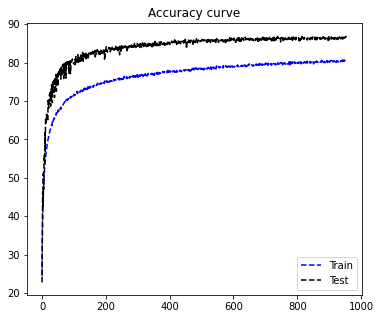

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
style = '--'

ax1.plot(train_acc, style, c='blue', label='Train')
ax1.plot(test_acc, style, c='black', label='Test')

ax1.title.set_text('Accuracy curve') 

ax1.legend()

plt.savefig('./plots/metrics_87.png')